In [1]:
# repository:
#     url: https://github.com/{your-book-url}


In [2]:
from numba import jit, cuda, float64
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.pyplot import figure
import random
import seaborn as sns
# np.random.seed(366)  #13699
# random.seed(764)     #586
sns.set()
import plotly.figure_factory as ff
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_percentage_error,mean_absolute_error

import scipy.linalg as sla
from struct_tools import DotDict

In [3]:
# data = pd.read_table('./GasProductionData_RateTime.txt')


In [4]:
# time = np.array(data['time'][1:])
# Rate=np.array(data['Rate'][1:])

In [5]:
# plt.plot(time,Rate,'o')

### Forward model functions

In [6]:
# # 'This function calculates the instantanous flow rate of an exponential decline curve
def hyperbolicArps(t,q0, Di, b):
    return q0 / (1 + b * Di * t) ** (1 / b)
def exponentialArps(q0, Di, t):
    return q0 * np.exp(-Di * t)
def harmonicArps(t, q0, Di):
    return q0/(1 + Di * t)
def ArpsRate(t,q0, Di, b): 
#     b=np.tanh(b)                                    #scaling to 0-1 dimension
#     b=np.where(b<0,0,b)                             #truncating
    b = np.where(b<=0, 10**-5,b)

    return np.where(b==0, exponentialArps(q0, Di, t),
                    np.where(b==1,harmonicArps(t, q0, Di),
                             hyperbolicArps(t,q0, Di, b)))
#SEM is being used for unconventinal field and here explain the turth for us.
def SEM(t,q0,Tau,n):
    Tau = np.where(Tau<=0, 10**-5,Tau)
    n = np.where(n<=0, 10**-5,n)
    return q0 *np.exp(-(t/Tau)**n)

In [7]:
def plotter(df,FM,tme):
    for i in range(len(range(tme))):
        plt.figure(figsize=(12,9))
        Q0=df[0,:,i]
        par1=df[1,:,i]
        par2=df[2,:,i]
     
        if FM=='Arps':
            Qt=ArpsRate(np.array([range(tme)]).T, Q0 ,par1 , par2)          #Arps(time, Q, Di0, b)
        else:
            Qt=SEM(np.array(([range(tme)])*N).T, Q0 ,par1,par2)  #SEM(time, Q, Tau, n)
     
        
        plt.errorbar(T,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7,)
        plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=7,alpha=.5)
        plt.plot(Qt)
        plt.title('Update after {} observastion '.format(i+1))
        plt.show()
    

In [8]:
def triangular_samples(minimum,mode,maximum,N_samples):
#     samples = np.zeros(int(N_samples))
    loc = minimum
    scale = maximum - minimum
    c = (mode - loc)/scale
    samples = ss.triang.rvs(c, loc, scale, N_samples)
    return samples

In [9]:
def uniform_samples(minimum, maximum, N_samples):
    samples = np.zeros(int(N_samples))
    loc = minimum
    scale = maximum - loc
    samples = ss.uniform.rvs(loc, scale, N_samples)
    return samples

In [10]:
def Normal_samples(mean_norm,sd_norm,N_samples):
    samples = np.zeros(int(N_samples))
    samples = ss.norm.rvs(mean_norm,sd_norm,N_samples)
    return samples

In [11]:
def lognormal_samples(mean_lognormal, sd_lognormal, N_samples):
#     samples = np.zeros(int(N_samples))
    mean_normal = np.log(mean_lognormal**2/np.sqrt(sd_lognormal**2+mean_lognormal**2))
    sd_normal = np.sqrt(np.log(1+sd_lognormal**2/mean_lognormal**2))
    samples = ss.lognorm.rvs(s=sd_normal, scale=np.exp(mean_normal), size=N_samples,)
    return samples

In [12]:
# Program to calculate moving average
def MA(arr, window_size):
    window_size = 3
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:
        window = arr[i : i + window_size]
        window_average = round(sum(window) / window_size, 2)
        moving_averages.append(window_average)
        i += 1

    return moving_averages

In [13]:
def p(arrY,lst, window_size=10):
    fig, ax = plt.subplots(figsize=(7,8))
    ss = pd.Series(arrY)
    ss.rolling(window_size).mean().plot(ax=ax,label='mean')
    ss.rolling(window_size).std().plot(ax=ax,label='STD')
    ss.rolling(window_size).quantile(.1, interpolation='linear').plot(ax=ax,label='P10')
    ss.rolling(window_size).quantile(.9, interpolation='linear').plot(ax=ax,label='P90')
    ss.rolling(window_size).quantile(.5, interpolation='linear').plot(ax=ax,label='P50')
    ax.legend()
    ax.set_ylabel("mismatch")
    ax.set_xlabel("model of Qt")
    sns.jointplot(data=lst)
def movingaverage(x,y, window_size=10):
    window = np.ones(int(window_size))/float(window_size)
    y_av = np.convolve(y, window, 'same')
    plt.figure(figsize=(7,8))
    plt.plot(x,y,"k.")
    plt.plot(x, y_av,"r")
    plt.xlim(0,1000)
    plt.xlabel("Model.")
    plt.ylabel("mismatich")
    plt.grid(True)
    plt.show()
# def plot_p():
def M(arrX,arrY, point,radious):
    df=np.vstack((arrX,arrY)).T
    lst=[]
    for i in range(len(arrX)):
        if (df[i,0]>= point-radious)& (df[i,0]<=point+radious):
            lst.append(df[i,1])
    if len(lst)==0:
        print( "Not in range")
        return 
    print(len(lst))        
    mu=np.mean(lst)
    sd=np.std(lst)
    PC=np.percentile(lst,[10,50,90])
    dic={'mean':[mu,'r'], 'STD': [sd,'b'], 'P10':[PC[0],'y'], 'P50':[PC[1],'g'], 'P90':[PC[2],'k']}
    #####
    movingaverage(arrX, arrY)
    p(arrY,lst)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
    sns.kdeplot(lst,ax=axes[0]).set_title("dist at point")
    for key, val in dic.items():
        axes[0].axvline(x=val[0],linewidth=4, color=val[1], label=key)
        axes[0].legend()
    return dic

In [14]:
def RMSE (predict, true):
    rmse= mean_squared_error(true, predict,squared= False)
#     acs = accuracy_score(true, predict, )
    mape = mean_absolute_error(true, predict)
    
    return rmse,mape


In [15]:
def error(df, FM, tme,tr ,obs):
    Q0=df[0,:,-1]
    par1=df[1,:,-1]
    par2=df[2,:,-1]
     
    if FM=='Arps':
        Qt=ArpsRate(np.array([range(tme)]).T, Q0 ,par1 , par2)          #Arps(time, Q, Di0, b)
    else:
        Qt=SEM(np.array(([range(tme)])*N).T, Q0 ,par1,par2)  #SEM(time, Q, Tau, n)
        
        
        
    rmse1,mape1 = RMSE ( (np.array(obs_SEM) * np.ones((N,len(T)))),Qt.T)
    rmse2,mape2 = RMSE ( (np.array(tr) * np.ones((N,len(T)))),Qt.T)
    
    print("RMSE SEM_update/measrment is ",rmse1)
    print("RMSE SEM_update/ture is ",rmse2)
    
#     print("accuracy_score SEM_update/measrment is ",acs1)
#     print("accuracy_score SEM_update/ture is ",acs2) 
    
    print("MAPE SEM_update/measrment is ",mape1)
    print("MAPE SEM_update/ture is ",mape2 )
    

In [16]:
def p(matY,lst, win_size_fraction=0.05):
    window_size=int(win_size_fraction*matY.size)    #fraction is about fraction of size of window to calculate needed paramter
    fig, ax = plt.subplots()
    ss = pd.Series(matY.flatten())
    ss.rolling(window_size).mean().plot(ax=ax,label='mean')
    ss.rolling(window_size).std().plot(ax=ax,label='STD')
    ss.rolling(window_size).quantile(.1, interpolation='linear').plot(ax=ax,label='P10')
    ss.rolling(window_size).quantile(.9, interpolation='linear').plot(ax=ax,label='P90')
    ss.rolling(window_size).quantile(.5, interpolation='linear').plot(ax=ax,label='P50')
    ax.legend()
    sns.jointplot(data=lst.flatten(),kind='hex')

##  Generating N realization of truth in time of production

In [17]:
N = 100 # No.Realization
prod_time=15 #times
T = np.arange(0,prod_time)
T = np.linspace(0,1,prod_time)
Q_SEM = np.zeros((prod_time,N))
SEM_par=np.zeros((3,N))
for i in range(N):
    Tau_sample = uniform_samples(.01,1,1)
    n_sample = uniform_samples(0.1,1,1)
    T = np.arange(0,prod_time)
#     Q1=np.linspace(0,1000,1)[::-1]     #Also can chane it in a way to make different Qini Q fin)
#     Q1=lognormal_samples(1000,5, 1)
    Q1=uniform_samples(100,1500,1)
    Q_SEM[:,i]=SEM(T,Q1,Tau_sample,n_sample)
    SEM_par[0,i]=Q1[0]
    SEM_par[1,i]=Tau_sample
    SEM_par[2,i]=n_sample
QS_DF=pd.DataFrame(Q_SEM,columns=['realization'+str(i) for i in range(N)])

# QS_DF['Time']=pd.Series(T)   

In [18]:
# QS_DF

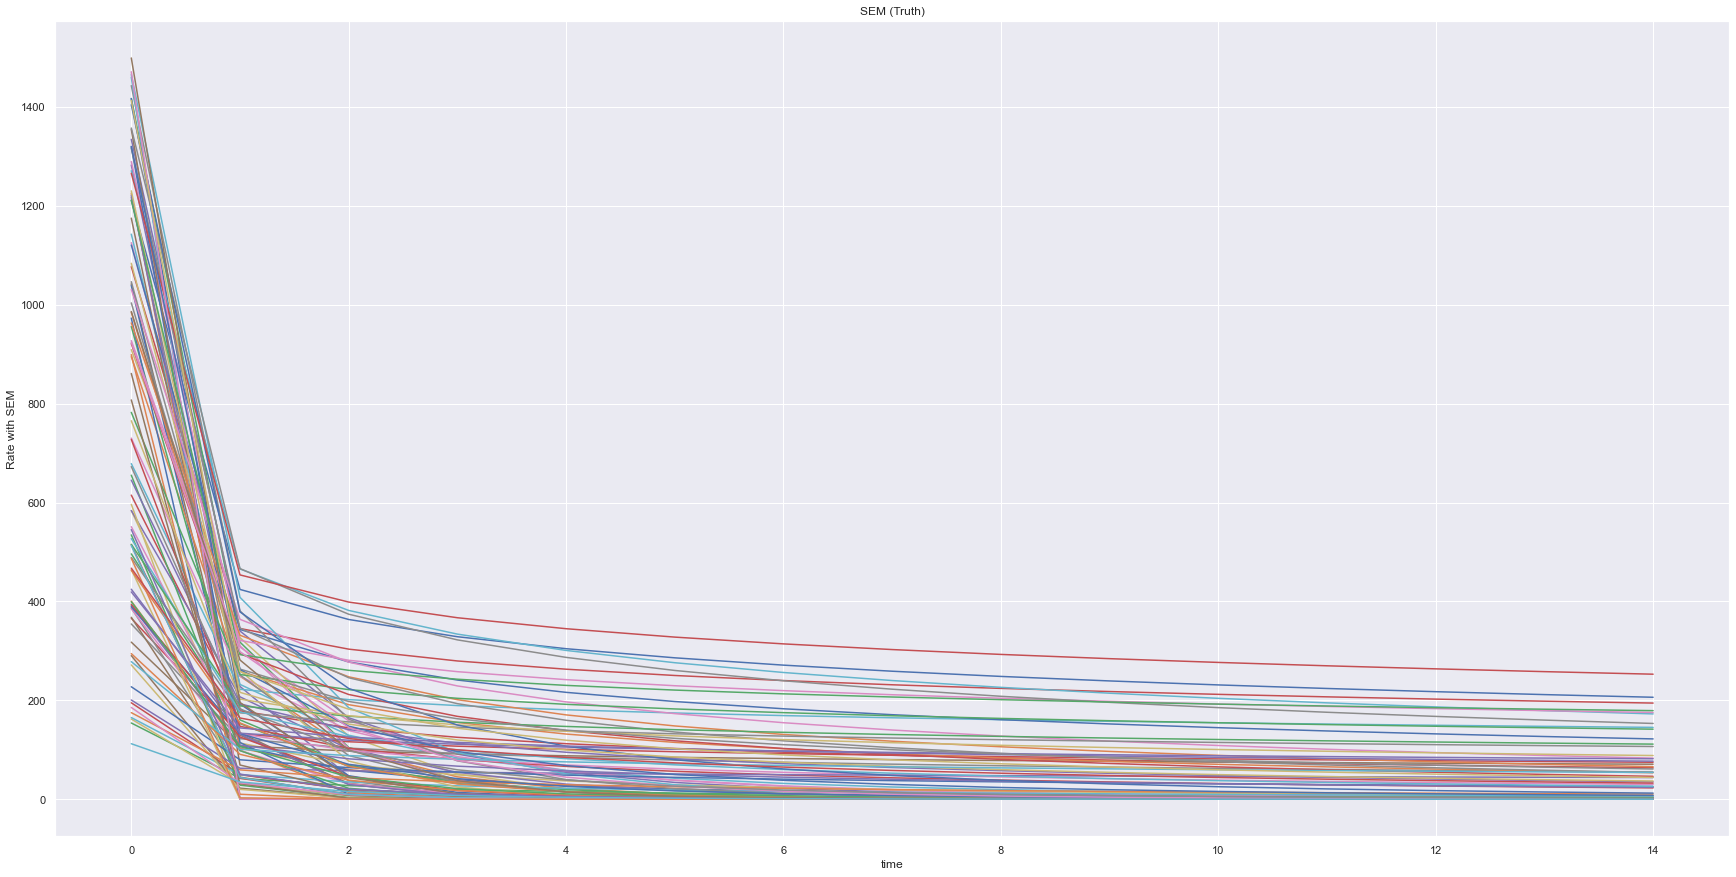

In [19]:
plt.figure(figsize=(30,15))
plt.plot(QS_DF)
plt.title('SEM (Truth)')
plt.xlabel('time')
plt.ylabel('Rate with SEM')
plt.show()

In [20]:
# SEM_T = go.Figure()
# for key, value in QS_DF.iteritems():
#     SEM_T.add_trace(go.Scatter(x=T, y=QS_DF[(key)], mode='lines', name=str(key), line=dict(color='gray')))
# SEM_T.update_layout(title={'text':'SEM Decline(True)','x':0.5,'y':0.85}, xaxis_title='Time (days)', yaxis_title='Oil Rate (bbl/day)')
# #fig_arps.update_layout(legend=dict(x=0.1,y=0.9,traceorder='normal',font=dict(size=15,)))
# SEM_T.show()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.9860e+05                                    1.18e+03    
       1              2         6.6946e+05      2.91e+04       2.51e+01       1.15e+03    
       2              3         6.6253e+05      6.93e+03       2.53e+01       1.06e+04    
       3              4         6.6116e+05      1.38e+03       7.64e-01       1.20e+03    
       4              5         6.5323e+05      7.92e+03       7.08e+00       1.20e+03    
       5              6         5.9625e+05      5.70e+04       5.01e+01       1.12e+03    
       6              7         4.9076e+05      1.05e+05       1.00e+02       1.00e+03    
       7              8         3.1197e+05      1.79e+05       2.00e+02       3.85e+03    
       8              9         7.8077e+04      2.34e+05       4.01e+02       1.16e+04    
       9             11         5.6651e+04      2.14e+04       5.55e+01       1.41e+04    

C:\Users\siava\anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:110: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


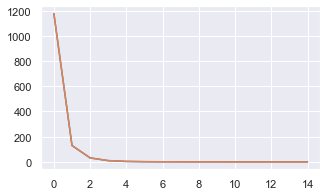

In [21]:
y=QS_DF['realization15']
T_=T
noise_sigma = T_/1
noise = np.ones((prod_time))   #np.random.randn(n) * noise_sigma
params2,cov = curve_fit(ArpsRate,T_,y/1,bounds=([0.0,.1,0.0],[np.inf,50,1]),method = 'dogbox',verbose=2,sigma=1/noise**2,ftol =1e-99, absolute_sigma=True)
                            # po:range ,sill ,nugget 
q = params2[0]
D = params2[1]
b = params2[2]

print('for exponential variogram')
print('Q is:',round(q,9))
print('D is:',round(D,4))
print('b:',round(b,8))
print(cov)
plt.figure(figsize=(5,3))
plt.plot(T_,y)
plt.plot(T_,ArpsRate(T,q, D,b))

In [22]:
para_mat=np.zeros((3,N))
Cov_mat=np.zeros((3,N,3))
T_=T/max(T)

noise_sigma = T_/20

for i,column in tqdm(enumerate(QS_DF)):
    noise = np.random.rand(prod_time) * noise_sigma
    noise[noise<=0]=.01
    params,cov = curve_fit(ArpsRate,T_,QS_DF[column]/1      ,method = 'trf',bounds=([0,.1,0.0001],[np.inf,3,.99999]),ftol=1.e-16,verbose=0,sigma=1/noise**2,
                           absolute_sigma=True)
    para_mat[:,i]=params
    Cov_mat[:,i,:]=cov
    

0it [00:00, ?it/s]

C:\Users\siava\anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:110: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


In [23]:
ARP_Mdl=np.zeros((prod_time,N))
for i in range(N):
    ARP_Mdl[:,i]=ArpsRate(T,para_mat[0,i],para_mat[1,i],para_mat[2,i])

In [24]:

ARPS_Model = go.Figure()
for i in range(N):
    ARPS_Model.add_trace(go.Scatter(x=T, y=ARP_Mdl[:,i], mode='lines', name='Model'+str(i)))
ARPS_Model.update_layout(title={'text':'Arps Model','x':0.5,'y':0.85}, xaxis_title='Time (days)', yaxis_title='Oil Rate (bbl/day)')
#fig_arps.update_layout(legend=dict(x=0.1,y=0.9,traceorder='normal',font=dict(size=15,)))
ARPS_Model.show()

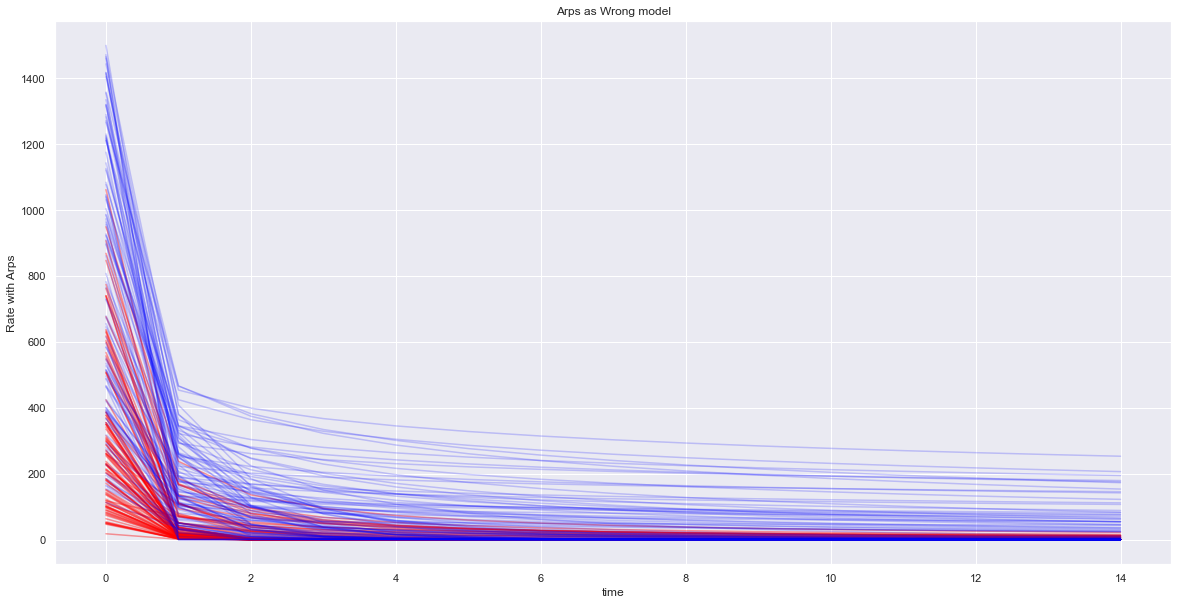

In [25]:
plt.figure(figsize=(20,10))
plt.plot(ARP_Mdl,color = 'red',alpha = 0.4)
plt.plot(QS_DF,color = 'blue',alpha = 0.2)
plt.title('Arps as Wrong model')
plt.xlabel('time')
plt.ylabel('Rate with Arps')
plt.show()

In [26]:
ARP_DF = pd.DataFrame(ARP_Mdl,columns=['realization'+str(i) for i in range(N)])

In [27]:
Mismatch = QS_DF- ARP_DF 

In [28]:
Mismatch.head(5)

realization0  realization1  realization2  realization3  realization4  \
0    342.870064    281.828010   1114.236422    229.973709   1050.919888   
1    238.691033     97.381846    302.650613    177.305466    216.605575   
2    269.345734     59.655773    104.038488    223.426030     45.866368   
3    268.061793     39.588680     38.555938    230.343763      9.882213   
4    260.738678     27.964201     15.174540    228.664278      2.177811   

   realization5  realization6  realization7  realization8  realization9  ...  \
0    838.609826    775.958355   1037.486120    567.786768    853.998034  ...   
1    124.370130    290.355916    174.293504    309.777120    217.904533  ...   
2     29.649436    157.744849     37.023913    126.671580    128.743505  ...   
3      7.872786     92.816141      8.429813     51.170838     83.596266  ...   
4      2.266681     58.244590      2.024051     20.943287     58.217232  ...   

   realization90  realization91  realization92  realization93  realization94  \
0     971.408073     410.718958     471.557706     167.568702     461.183913   
1     244.660526      -0.975096     126.605740     142.177825      46.575708   
2     146.927271      -0.137255     173.328144     119.968758      20.123724   
3      96.585814      -0.008094     184.946676      99.400159      10.177092   
4      68.048953      -0.000429     187.713715      84.563146       5.722324   

   realization95  realization96  realization97  realization98  realization99  
0     714.635523     694.822157     435.394838     651.274483      94.639881  
1     268.080352     287.127145     170.788273     220.416317      34.171533  
2      98.664739     144.687801      97.160453     180.164095      15.417273  
3      37.447070      78.201956      59.467207     143.494571       7.490302  
4      14.735849      44.643185      38.780053     119.344182       3.836166  

[5 rows x 100 columns]

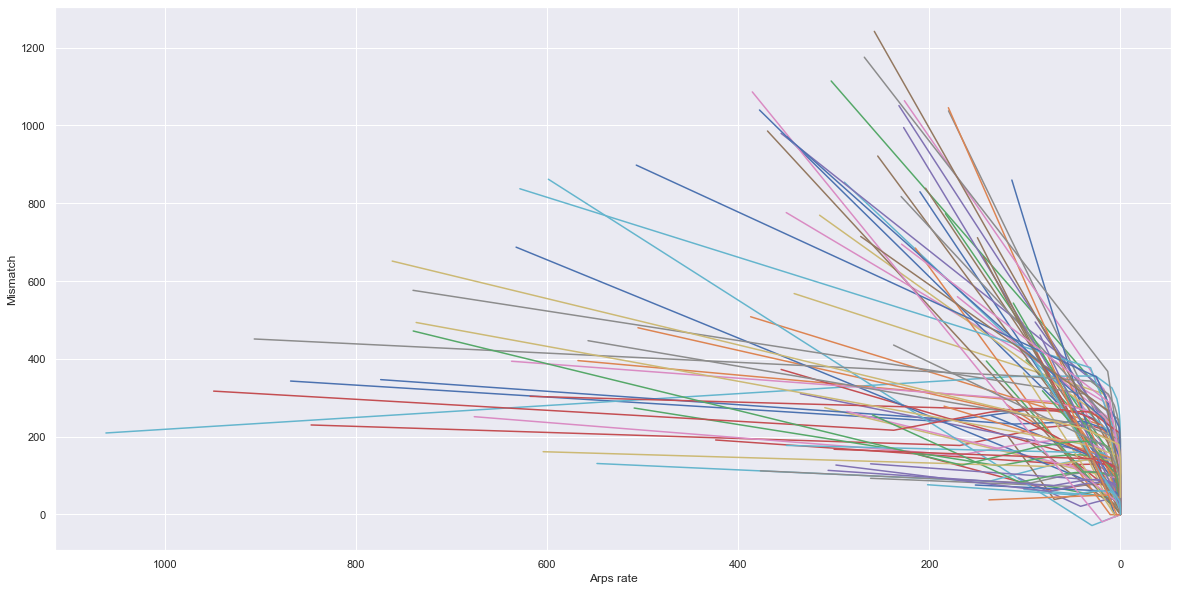

In [29]:
plt.figure(figsize=(20,10))
plt.plot(ARP_DF,Mismatch)
plt.xlabel('Arps rate')
plt.ylabel('Mismatch')
plt.gca().invert_xaxis()
plt.show()

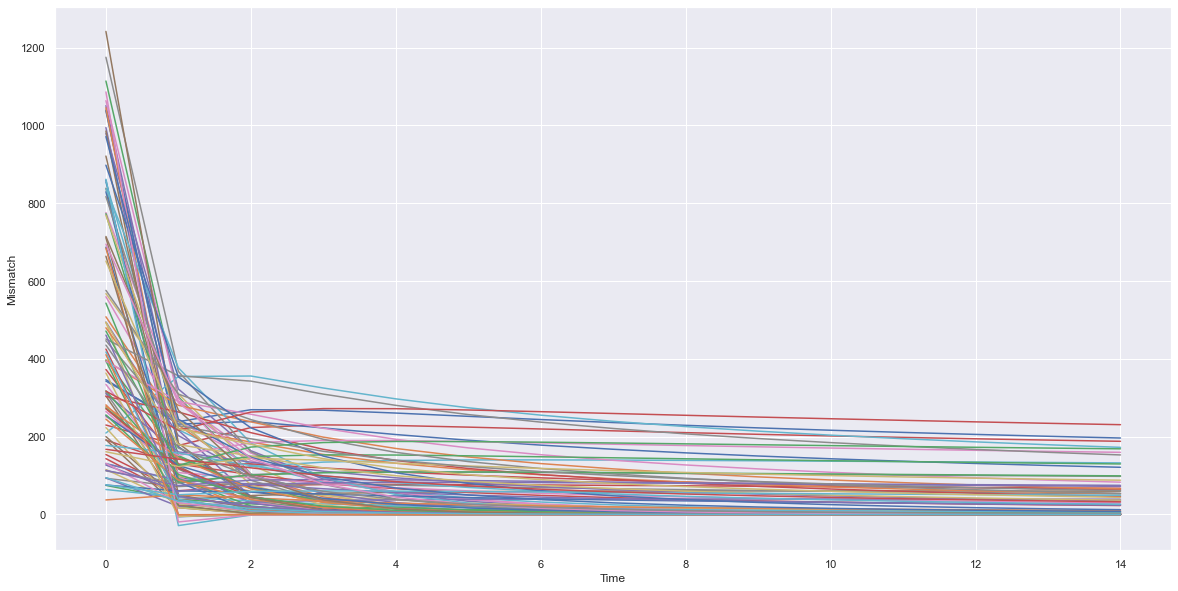

In [30]:
plt.figure(figsize=(20,10))
plt.plot(T,Mismatch)
plt.xlabel('Time')
plt.ylabel('Mismatch')
# plt.gca().invert_xaxis()
plt.show()

In [31]:
# @cuda.jit 
def M_A(matX,matY,win_size):
    mn_range=np.min(matX); mx_range=np.max(matX)
    flt_X=matX.flatten()
    flt_Y=matY.flatten()
    save_mat=list()
    for p in tqdm(flt_X):
        lstX=list()
        lstY=list()
        for j in range(len(flt_X)):
            if (flt_X[j]>= (p/2-win_size))& (flt_X[j]<=p/2+win_size):
                lstY.append(flt_Y[j])
                lstX.append(flt_X[j])
        if len(lstY)==0:
            print( "Not in range")
            return
#         CrCo_M=np.corrcoef(lstX,lstY)   
        mu=np.mean(lstY)
        sd=np.std(lstY)
#         PC=np.percentile(lstY,[10,50,90])
#         dic={'x':p,'mean':mu, 'STD': sd, 'P10':PC[0], 'P50':PC[1], 'P90':PC[2],'Cor_Coef':CrCo_M[0,1]}
        dic={'x':p,'mean':mu, 'STD': sd} 
        save_mat.append(dic)    
    df= pd.DataFrame.from_dict(save_mat)
    df.sort_values(by=['x'],ascending=False, inplace=True)
    fig1 = go.Figure([
    go.Scatter(
        name='ave',
        x=df['x'],
        y=df['mean'],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
#     go.Scatter(
#         name='P10',
#         x=df['x'], 
#         y=df['P10'], 
#         line=dict(color='rgba(255,255,255)'),
        
#     ),
#         go.Scatter(
#         name='P90',   
#         x=df['x'], 
#         y=df['P90'], 
#         line=dict(color='rgba(255,0,255)'),
        
#     ),
#       go.Scatter(
#         name='P50' ,   
#         x=df['x'], 
#         y=df['P50'], 
#         line=dict(color='rgba(255,255,0)'),
        
#     ),
    
        go.Scatter(
        name='STD' ,   
        x=df['x'], 
        y=df['STD'],
        line=dict(color='rgba(255,255,0)'),
        
    )])
    fig1.update_layout(
    xaxis=dict(visible=True,autorange='reversed'),    
    title="",
    xaxis_title="Arps rate(model)",
    yaxis_title="Mismatch",
    legend_title="window size{}".format(win_size),
    font=dict(
        family="Courier New, monospace",
        size=12
    ))
    fig1.show() 
#     fig2 = go.Figure([
#     go.Scatter(
#         name='Cor_Coef',
#         x=df['x'],
#         y=df['Cor_Coef'],
#         line=dict(color='rgb(0,100,80)'),
#         mode='lines'
#     )])
    
#     fig2.update_layout(
#     xaxis=dict(visible=True,autorange='reversed'),    
#     title="",
#     xaxis_title="Arps rate(model)",
#     yaxis_title="Correlation coefficients(Peasron) of Mismatch",
#     legend_title="window size {}".format(win_size),
#     font=dict(
#         family="Courier New, monospace",
#         size=12
#     )),

#     fig2.show()
    return df

In [32]:
df_out=M_A(np.array(ARP_DF),np.array(Mismatch),win_size=100)  
# df_out=M_A(np.array(T),np.array(Mismatch),win_size=1)  

  0%|          | 0/1500 [00:00<?, ?it/s]

In [33]:
df_out

x        mean         STD
29    1.061920e+03  478.824406  274.479484
83    9.491588e+02  505.641358  335.791020
77    9.066728e+02  588.155629  366.941716
0     8.686506e+02  608.121140  338.076245
3     8.471773e+02  608.121140  338.076245
...            ...         ...         ...
1426  3.196410e-17   55.091744   77.549788
1481  3.109791e-17   55.091744   77.549788
1458  3.030795e-17   55.091744   77.549788
1438  2.923459e-17   55.091744   77.549788
1499  1.108472e-17   55.091744   77.549788

[1500 rows x 3 columns]

In [34]:
# print('totlal',len(df_out))
# print('more than 800is',len(df_out[df_out['x']>800]))
# print('less than 300is',len(df_out[df_out['x']<300]))

In [35]:
# lst_size=np.arange(100,990,100)
# for i in lst_size:
#     M_A(np.array(ARP_DF),np.array(Mismatch),win_size=i)  

In [36]:
def M_A1(matX,matY,win_size):
    mn_range=np.min(matX); mx_range=np.max(matX)
    flt_X=matX.flatten()
    flt_Y=matY.flatten()
    
    save_mat=[]
    for p in tqdm(flt_X):
        lstX=[]
        lstY=[]
        
        for j in range(len(flt_X)):
            if (flt_X[j]>= (p/2-win_size))& (flt_X[j]<=p/2+win_size):
                lstY.append(flt_Y[j])
                lstX.append(flt_X[j])
        if len(lstY)==0:
            print( "Not in range")
            return
#         CrCo_M=np.corrcoef(lstX,lstY)   
        mu=np.mean(lstY)
        sd=np.std(lstY)
#         PC=np.percentile(lstY,[10,50,90])
#         dic={'x':p,'mean':mu, 'STD': sd, 'P10':PC[0], 'P50':PC[1], 'P90':PC[2],'Cor_Coef':CrCo_M[0,1]}
        dic={'x':p,'mean':mu, 'STD': sd}
        save_mat.append(dic)
    df= pd.DataFrame.from_dict(save_mat)
    df.sort_values(by=['x'],ascending=False, inplace=True)    
    return df

# how to score ???????
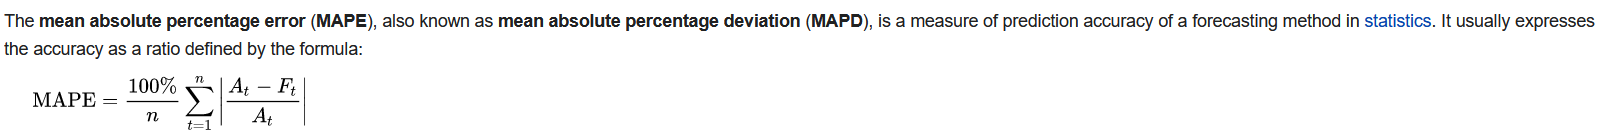

In [37]:
def MA_CV(matX,matY,win_size,K=.5):
    mn_range=np.min(matX); mx_range=np.max(matX)
    matX=matX.flatten()
    matY=matY.flatten()    
    flt_X, X_test, flt_Y, y_test = train_test_split(matX, matY, test_size=K, random_state=77)
    trn=M_A1(flt_X,flt_Y,win_size)
    tst=M_A1(X_test,y_test,win_size)
#     score=1-(trn.div(tst))
    return trn,tst

In [38]:
trng,tst=MA_CV(np.array(ARP_DF),np.array(Mismatch),win_size=100,K=.2)  

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [39]:
ARP_DF

realization0  realization1  realization2  realization3  realization4  \
0     868.650572  1.189017e+02  3.028168e+02    847.177269  2.319040e+02   
1     185.694588  5.922433e+00  1.508314e+01    168.072223  1.155102e+01   
2      94.254680  2.952587e-01  7.519595e-01     80.190825  5.758678e-01   
3      60.679805  1.473315e-02  3.752213e-02     49.355398  2.873530e-02   
4      43.766276  7.358323e-04  1.874004e-03     34.372351  1.435155e-03   
5      33.749904  3.678340e-05  9.367930e-05     25.756992  7.174175e-05   
6      27.199097  1.840410e-06  4.687124e-06     20.260733  3.589506e-06   
7      22.616250  9.216518e-08  2.347246e-07     16.497236  1.797575e-07   
8      19.249828  4.619642e-09  1.176522e-08     13.784349  9.010074e-09   
9      16.683720  2.317602e-10  5.902426e-10     11.750925  4.520212e-10   
10     14.670008  1.163745e-11  2.963806e-11     10.179291  2.269750e-11   
11     13.052345  5.848786e-13  1.489558e-12      8.934117  1.140738e-12   
12     11.727540  2.942129e-14  7.492962e-14      7.927253  5.738281e-14   
13     10.624911  1.481310e-15  3.772573e-15      7.099038  2.889122e-15   
14      9.694509  7.464794e-17  1.901120e-16      6.407787  1.455921e-16   

    realization5  realization6  realization7  realization8  realization9  ...  \
0   2.040253e+02  3.498221e+02  1.799737e+02  3.415771e+02  2.890123e+02  ...   
1   1.016239e+01  1.742445e+01  8.964393e+00  1.701377e+01  1.439555e+01  ...   
2   5.066388e-01  8.686839e-01  4.469135e-01  8.482097e-01  7.176801e-01  ...   
3   2.528084e-02  4.334657e-02  2.230059e-02  4.232492e-02  3.581161e-02  ...   
4   1.262626e-03  2.164900e-03  1.113780e-03  2.113875e-03  1.788574e-03  ...   
5   6.311719e-05  1.082209e-04  5.567659e-05  1.056702e-04  8.940876e-05  ...   
6   3.157988e-06  5.414691e-06  2.785707e-06  5.287071e-06  4.473453e-06  ...   
7   1.581476e-07  2.711602e-07  1.395043e-07  2.647691e-07  2.240243e-07  ...   
8   7.926913e-09  1.359150e-08  6.992445e-09  1.327116e-08  1.122888e-08  ...   
9   3.976807e-10  6.818641e-10  3.507999e-10  6.657931e-10  5.633353e-10  ...   
10  1.996888e-11  3.423868e-11  1.761484e-11  3.343170e-11  2.828695e-11  ...   
11  1.003602e-12  1.720778e-12  8.852919e-13  1.680220e-12  1.421654e-12  ...   
12  5.048444e-14  8.656071e-14  4.453306e-14  8.452054e-14  7.151382e-14  ...   
13  2.541802e-15  4.358178e-15  2.242160e-15  4.255459e-15  3.600593e-15  ...   
14  1.280895e-16  2.196225e-16  1.129896e-16  2.144462e-16  1.814454e-16  ...   

    realization90  realization91  realization92  realization93  realization94  \
0    3.492777e+02   7.650319e+01     740.294994     299.804724   8.421727e+01   
1    1.739734e+01   3.810584e+00     165.938376      22.174259   4.194818e+00   
2    8.673320e-01   1.899740e-01      87.439725       2.889819   2.091297e-01   
3    4.327911e-02   9.479536e-03      57.820621       0.541712   1.043539e-02   
4    2.161531e-03   4.734457e-04      42.577183       0.130813   5.211849e-04   
5    1.080524e-04   2.366700e-05      33.391582       0.038069   2.605343e-05   
6    5.406265e-06   1.184148e-06      27.295762       0.012785   1.303550e-06   
7    2.707382e-07   5.930049e-08      22.977253       0.004809   6.527996e-08   
8    1.357035e-08   2.972348e-09      19.769791       0.001984   3.272060e-09   
9    6.808029e-10   1.491180e-10      17.300680       0.000883   1.641541e-10   
10   3.418540e-11   7.487716e-12      15.345820       0.000419   8.242728e-12   
11   1.718100e-12   3.763198e-13      13.762698       0.000210   4.142654e-13   
12   8.642600e-14   1.893011e-14      12.456535       0.000110   2.083890e-14   
13   4.351395e-15   9.530973e-16      11.361947       0.000060   1.049201e-15   
14   2.192807e-16   4.802962e-17      10.432432       0.000034   5.287262e-17   

    realization95  realization96  realization97  realization98  realization99  
0    2.719519e+02   2.291752e+02   2.374633e+02   7.622784e+02   1.765611e+01  
1    1.354578e+01   1.141509e+01 

In [40]:
tst.reset_index(drop=True,inplace=True)
tst

x        mean         STD
0    6.286605e+02  595.199378  378.630922
1    6.042925e+02  595.199378  378.630922
2    5.573183e+02  533.980198  366.376879
3    5.068007e+02  536.130252  350.851630
4    3.492777e+02  444.557403  364.421235
..            ...         ...         ...
295  8.813727e-17   55.613711   75.195817
296  6.200926e-17   55.613711   75.195817
297  3.973702e-17   55.613711   75.195817
298  2.923459e-17   55.613711   75.195817
299  1.108472e-17   55.613711   75.195817

[300 rows x 3 columns]

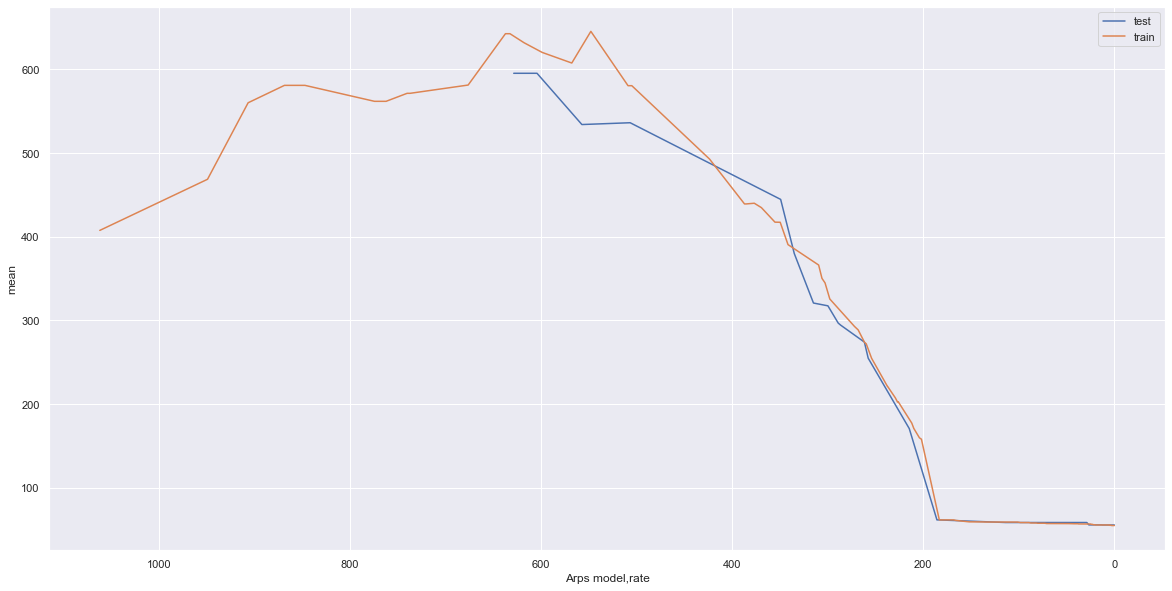

In [41]:
plt.figure(figsize=(20,10))
plt.plot(tst['x'],tst['mean'],label='test')
plt.plot(trng['x'],trng['mean'],label='train')
plt.legend()
plt.xlabel('Arps model,rate')
plt.ylabel('mean')
plt.gca().invert_xaxis()
plt.show()

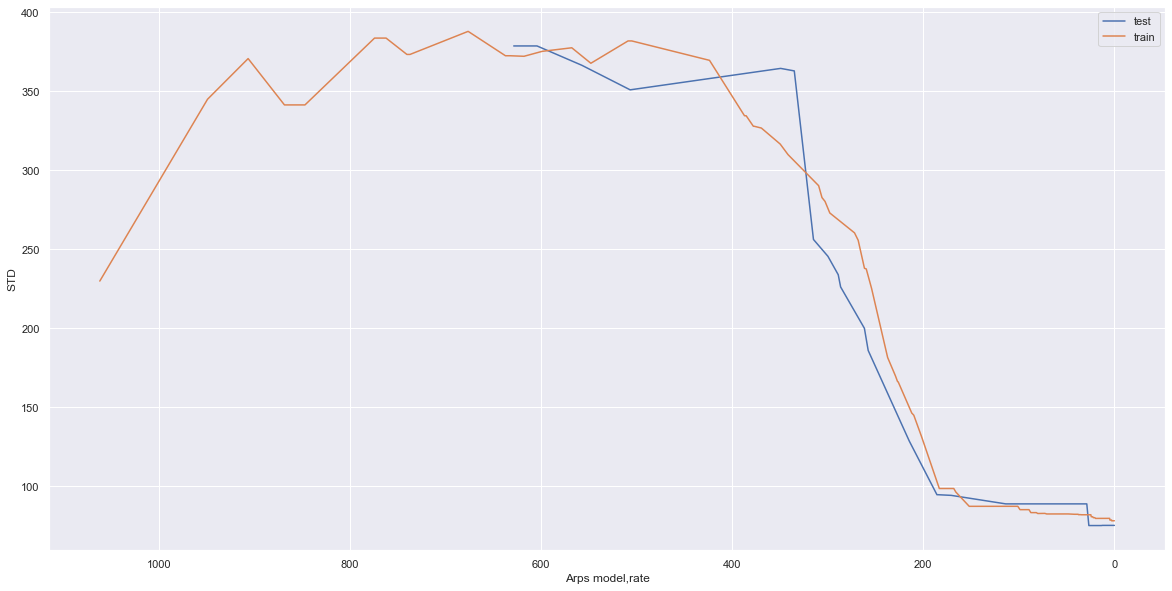

In [42]:

plt.figure(figsize=(20,10))
plt.plot(tst['x'],tst['STD'],label='test')
plt.plot(trng['x'],trng['STD'],label='train')
plt.legend()
plt.xlabel('Arps model,rate')
plt.ylabel('STD')
plt.gca().invert_xaxis()
plt.show()

In [43]:
# plt.figure(figsize=(20,10))
# plt.plot(tst['x'],tst['Cor_Coef'],label='test')
# plt.plot(trng['x'],trng['Cor_Coef'],label='train')
# plt.legend()
# plt.xlabel('Arps model,rate')
# plt.ylabel('Cor_Coef')
# plt.gca().invert_xaxis()
# plt.show()


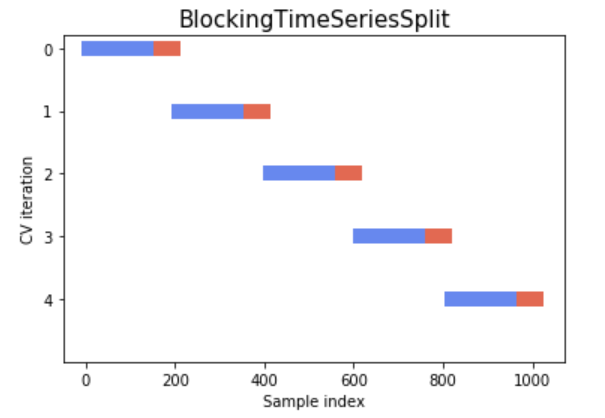

In [44]:
sft=df_out-df_out.shift(1)

In [45]:
# df_out['x']

In [46]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['mean'],label='shifted-mean',alpha=.5)
# plt.scatter(df_out['x'],sft['P50'],label='shifted-P50',alpha=.5)
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in mean')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()


In [47]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['STD'],label='shifted-STD')
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in STD')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

In [48]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['P10'],label='shifted-P10')
# plt.scatter(df_out['x'],sft['P90'],label='shifted-P90')
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in shifted precentiles')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

In [49]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['Cor_Coef'],label='shifted-Cor_Coef')
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in shifted Cor_Coef')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

### Generating _Truth_ and _Observation_ with SEM Model

In [50]:
# def obsv(df,obs_num, sd ,percent=1,mu=0):
#     rnd=random.randint(0,N-1)
#     tr = df['realization'+str(rnd)]
#     d = tr + np.random.normal(mu, sd,len(tr+0))    # adding noise to 15 y as observation
#     prop = len(d)*percent/obs_num
#     intr = np.arange(0,len(d)*percent,prop )+1
#     obs_mat=np.zeros(int(obs_num));idx=[]
#     for count,inx in enumerate(intr):
#         obs_mat[count]=d[int(inx)]
#         idx.append(int(inx))
#     return obs_mat,idx,prop,tr

In [51]:
def obsv1(df, sd ,mu=0):
    rnd=random.randint(0,N-1)
    tr = df['realization'+str(rnd)]
    obs_mat = tr + np.random.normal(mu, sd,len(tr+0))    # adding noise to 15 y as observation
    obs_mat = np.where(obs_mat<0,0,obs_mat)
    return obs_mat,tr

In [52]:
# obs_SEM, indx,_, tr=obsv(QS_DF,11 , sd=10)
# indx
obs_SEM,tr=obsv1(QS_DF, sd=50)
obs_SEM
tr

0     419.343712
1     144.230465
2     125.659888
3     114.989498
4     107.548828
5     101.868597
6      97.294915
7      93.479861
8      90.216436
9      87.371612
10     84.854907
11     82.602037
12     80.565725
13     78.710209
14     77.007800
Name: realization84, dtype: float64

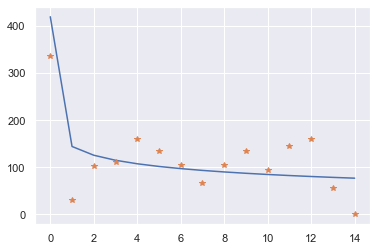

In [53]:
plt.plot(tr)
plt.plot(obs_SEM,'*')
    

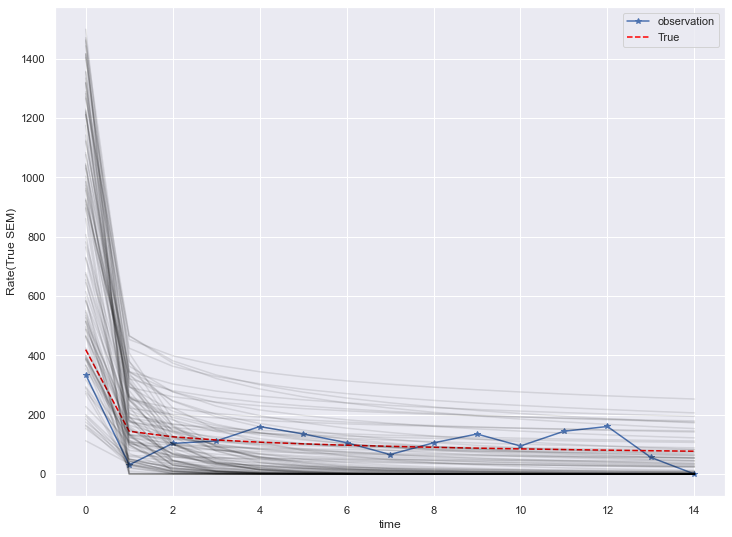

In [54]:
# rnd=random.randint(0,N-1)
# tr = QS_DF['realization'+str(rnd)]
# obs_SEM = tr + ss.norm.rvs(0,20,prod_time)
plt.figure(figsize=(12,9))
plt.plot(T,obs_SEM, 'b-*',label='observation')
plt.plot(T,tr,label='True', color='red',linestyle='--')
plt.plot(QS_DF,alpha=.1,color='black')
plt.ylabel('Rate(True SEM)')
plt.xlabel('time')
plt.legend()
plt.show()

In [55]:
# fig_stats = go.Figure()
# fig_stats.add_trace(go.Scatter(x=T, y=Tru_SEM, mode='lines', name='Truth', line=dict(color='red')))
# fig_stats.add_trace(go.Scatter(x=np.asarray(obs_SEM)[:,0], y=np.asarray(obs_SEM)[:,1], mode='markers', name='measurment', line=dict(color='blue')))
# fig_stats.update_layout(legend=dict(x=0.8,y=0.9,traceorder='normal',font=dict(size=15,)))
# fig_stats.show()

# EnKF V3

In [56]:
def EnKF(mf_k,Xf_k, gf_k, d, par1, par2, FM, pa_up,tme ,st_df=0, r=.5):
    np.random.seed(1366)
    random.seed(586)
    R = r * np.eye(1)
    N=mf_k.shape[1]
    nobs=(obs_SEM).shape[0]
    Y_f_ = np.zeros([5,N,nobs+1])
    P_f_ = np.zeros([5,5,nobs+1])
    Y_a_ = np.zeros([5,N,nobs+1])
    P_a_ = np.zeros([5,5,nobs+1])
    Y_f_[0,:,0] = mf_k
    Y_f_[3,:,0] = mf_k
    Y_f_[4,:,0] = mf_k
    Y_f_[1,:,0] = par1; Y_f_[2,:,0] = par2
    P_f_[:,:,0] = np.cov(Y_f_[:,:,0])
    Y_a_[0,:,0] = mf_k
    Y_a_[3,:,0] = mf_k
    Y_a_[4,:,0] = mf_k
    Y_a_[1,:,0] = par1; Y_a_[2,:,0] = par2
    P_a_[:,:,0] = np.cov(Y_a_[:,:,0])
    for t in tqdm(range(nobs)):
        Q0 = Y_a_[0,:,t]

        if FM=='Arps':
            Qt=ArpsRate(np.array([range(tme)]).T, Q0 ,Y_f_[1,:,0] , Y_f_[2,:,0])  #Arps(time, Q, Di0, b)
        else:
            
            Qt=SEM(np.array(([range(tme)])*N).T, Q0 ,Y_f_[1,:,0],Y_f_[2,:,0])     #SEM(time, Q, Tau, n)
        Y_f_[0,:,t+1] = np.abs(Q0)
        Y_f_[3,:,t+1] = Qt[t,:]
        Y_f_[4,:,t+1] = Qt[t,:]
        Y_a_[1,:,t] = np.where(Y_a_[1,:,t]<=0,10**-6,Y_a_[1,:,t])
        Y_a_[2,:,t] = np.where(Y_a_[2,:,t]<=0,10**-6,Y_a_[2,:,t])
        if pa_up== True:

            Y_f_[1,:,t+1] = Y_a_[1,:,t];Y_f_[2,:,t+1] = Y_a_[2,:,t]
             
        else:
            Y_f_[1,:,t+1] = Y_a_[1,:,0];Y_f_[2,:,t+1] = Y_a_[2,:,0]
            
        Y_f_now = Y_f_[:,:,t+1]
        P_f_now = np.cov(Y_f_now)*N/np.sqrt(N-1)
        P_f_[:,:,t+1] = P_f_now
        H = np.array([Qt[t,:] @  sla.pinv(Y_f_now)])   
        K = P_f_now @ H.T @ sla.pinv(H @ P_f_now @ H.T + R)
        y = d[t] + ss.norm.rvs(0,r,1) # measurement + noise
        Y_a_now = Y_f_now + K @ (y - H @ Y_f_now)
#         print("iteration", t)
#         print('p1',Y_f_now[1,2:4])
#         print('p2',Y_f_now[2,2:4])

#         print(np.min(Y_a_now[1,:]))

        Y_a_now[1,:] = np.where(Y_a_now[1,:]<=0,10**-5, Y_a_now[1,:])
        Y_a_now[2,:] = np.where(Y_a_now[2,:]<=0,10**-5, Y_a_now[2,:])
        P_a_now = np.cov(Y_a_now)
        Y_a_[:,:,t+1] = Y_a_now
        P_a_[:,:,t+1] = P_a_now
        
    return Y_a_

In [57]:
Arps_updated= EnKF(mf_k=np.matrix(para_mat[0,:]),                      #state_variables,, 
                    Xf_k=np.array(ARP_DF),                            #dynamic_reservoir_model
                    gf_k=np.array(ARP_DF),                           #observation_current
                    d=np.asarray(obs_SEM),                            #measurements
                    par1=(para_mat[1,:]),                             #paramter1
                    par2=(para_mat[2,:]),                             #parameter2                                                    
                    r=50,                                             # measurements error (STD)
                    FM='Arps',                                        #forward model
                    st_df= df_out,                                     #statistical data
                   pa_up=True,                                        #updating parameters
                  tme=prod_time)



# print("RMSE Arps_updated/measurment is ",RMSE ( (np.array(obs_SEM) * np.ones((N,len(T)))),Arps_updated[4,:,1:]))
# print("RMSE Arps_updated/true is ",RMSE ( (np.array(tr) * np.ones((N,len(T)))),Arps_updated[4,:,1:]))

  0%|          | 0/15 [00:00<?, ?it/s]

In [58]:
# q0=Arps_updated[0,:,-1]
# D=Arps_updated[1,:,-1]
# B=Arps_updated[2,:,-1]
# aP=ArpsRate(np.array([range(prod_time)]).T, q0, D, B)
# # plt.plot(aP)
# plt.show()

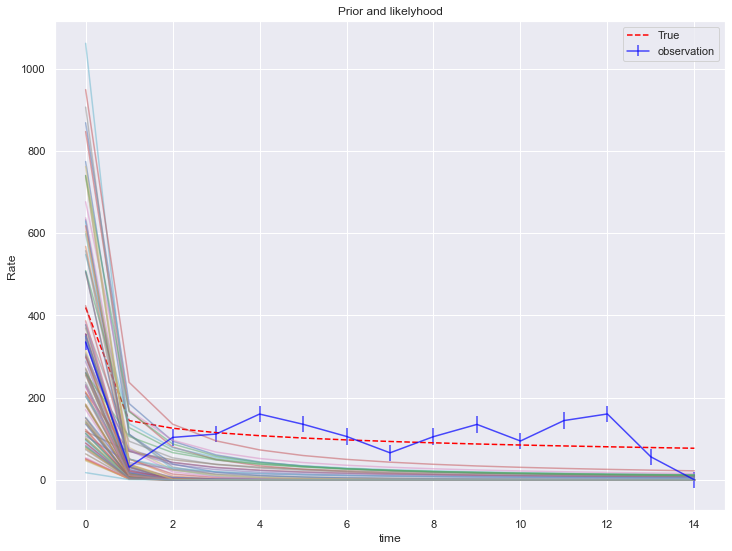

In [59]:
plt.figure(figsize=(12,9))
plt.errorbar(T,np.asarray(obs_SEM), yerr = 20,color='blue',label='observation',alpha=.7)
plt.plot(T,tr,label='True', color='red',linestyle='--')
# plt.plot(aP)
plt.plot(T,ARP_DF,alpha=.5)
plt.ylabel('Rate')
plt.xlabel('time')
plt.title('Prior and likelyhood')
plt.legend()
plt.show()

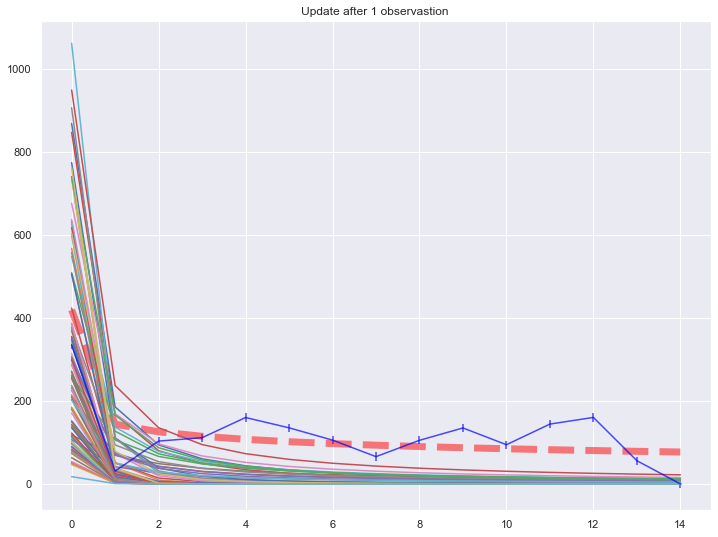

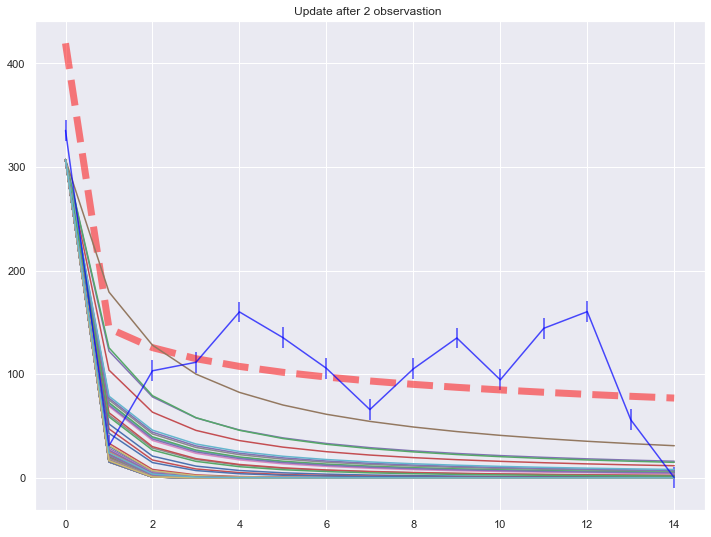

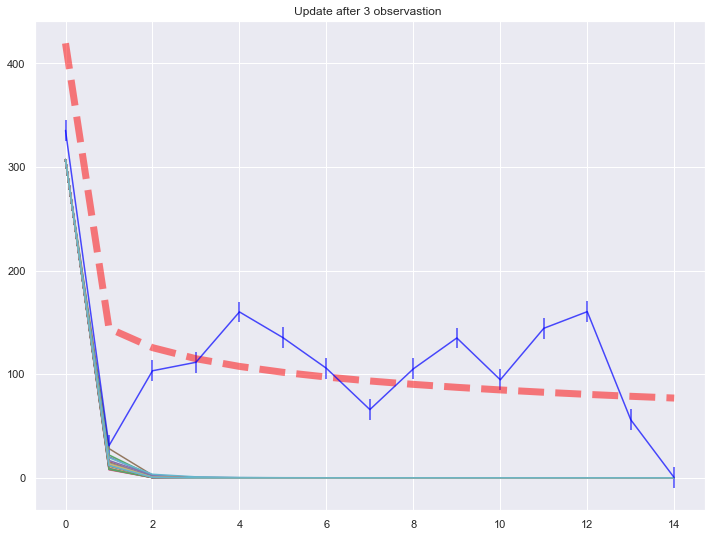

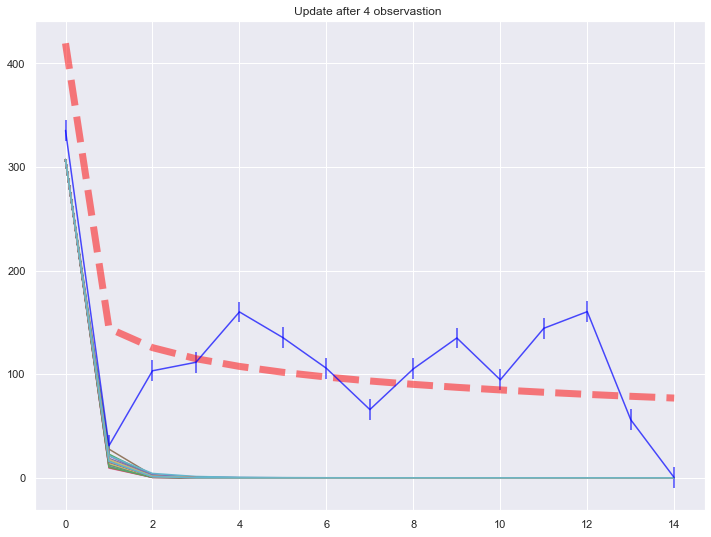

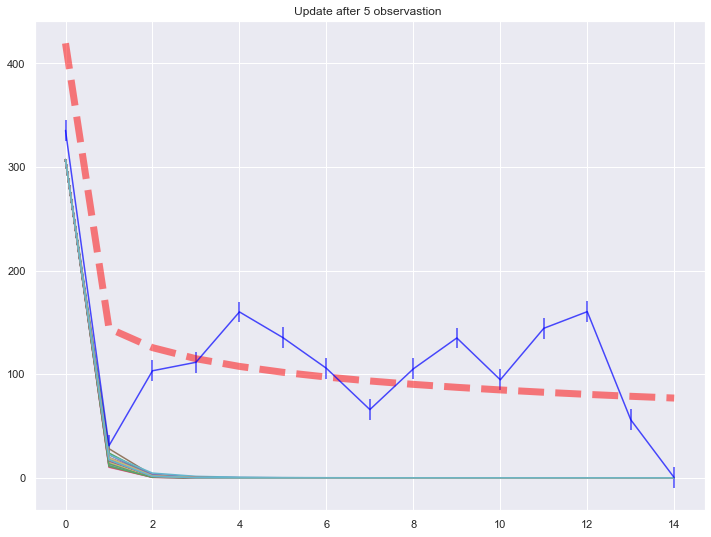

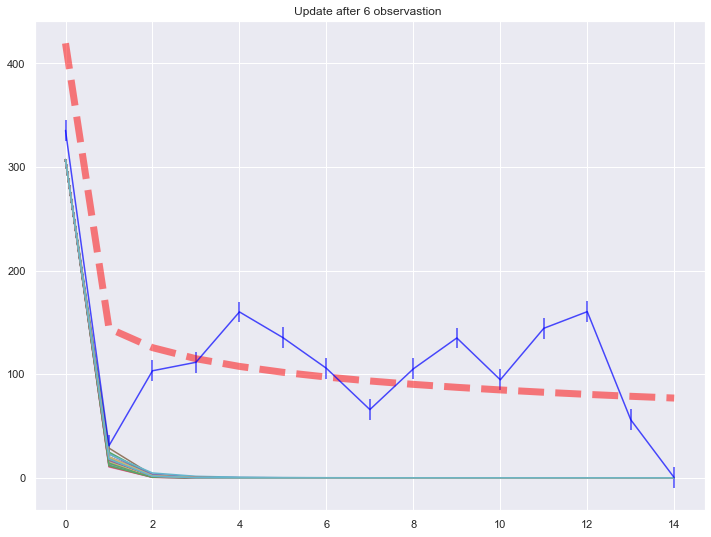

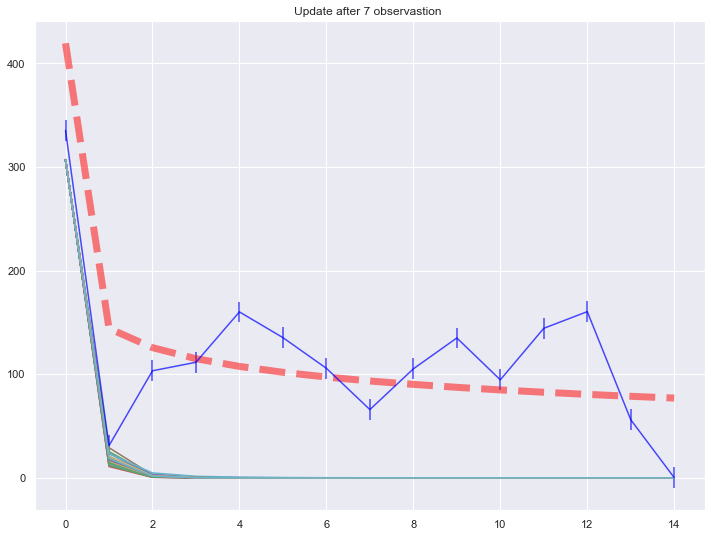

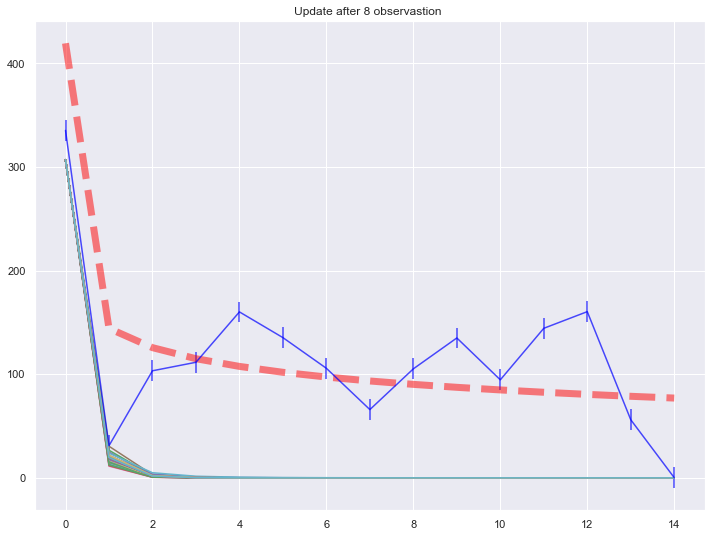

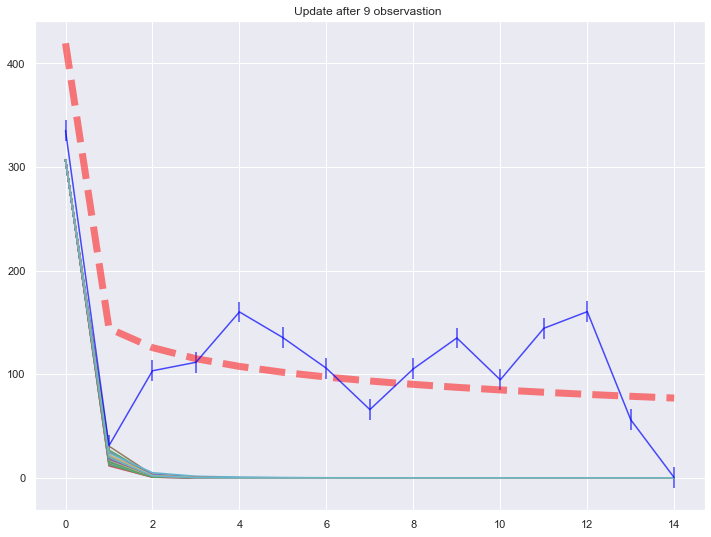

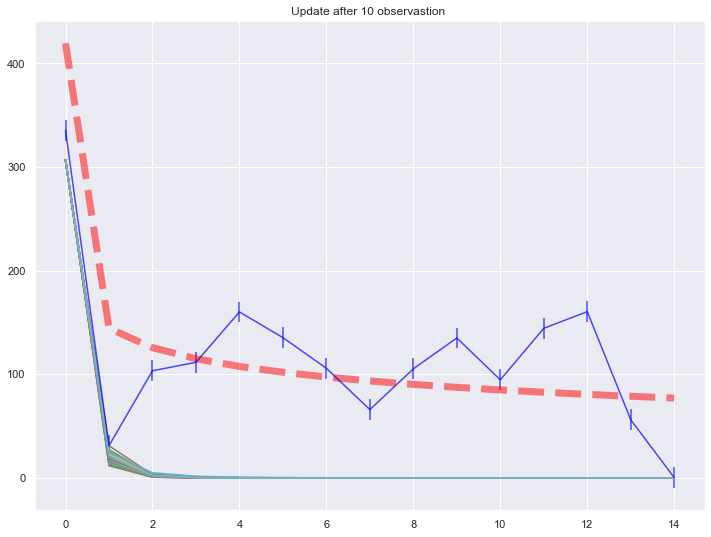

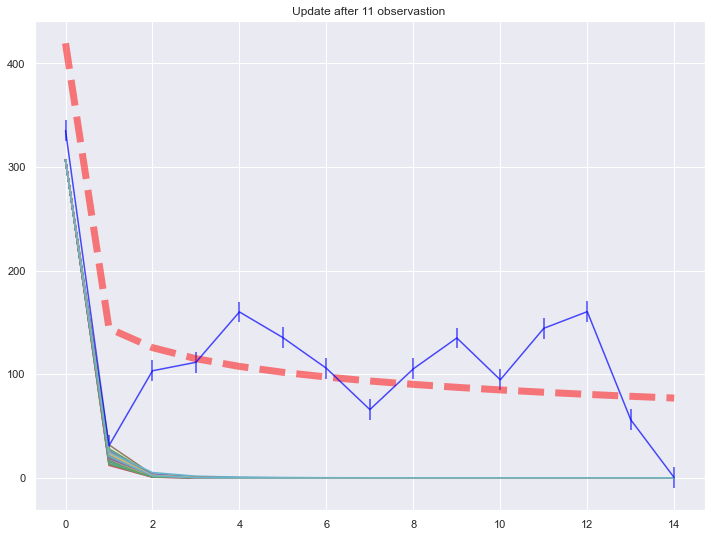

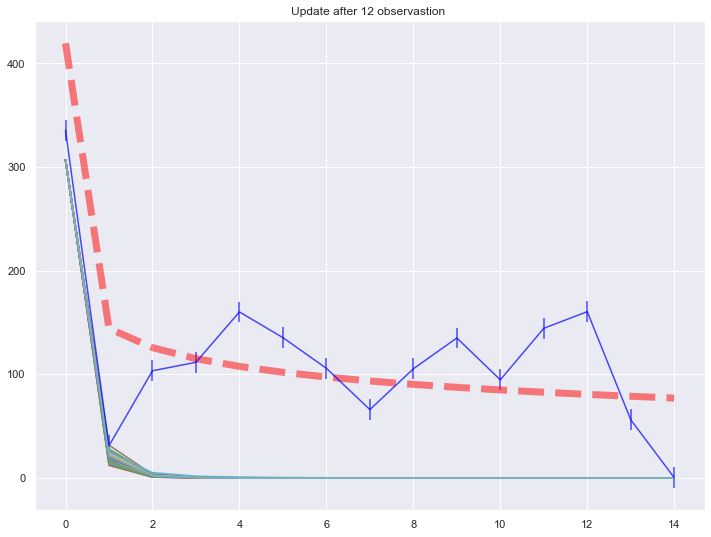

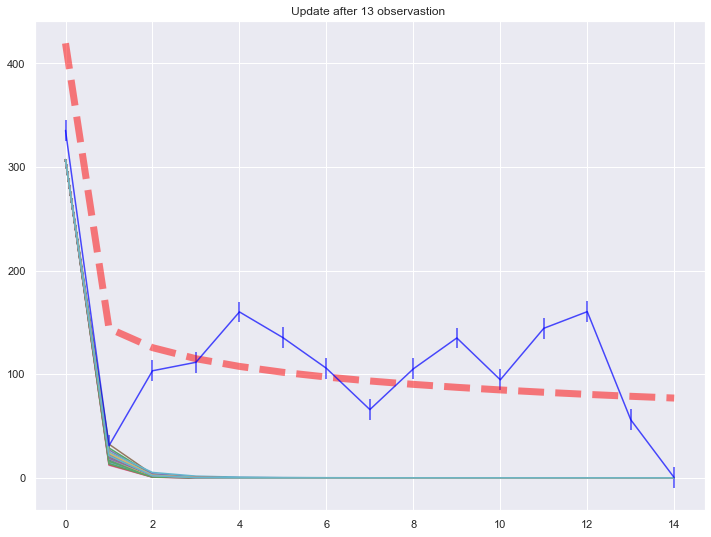

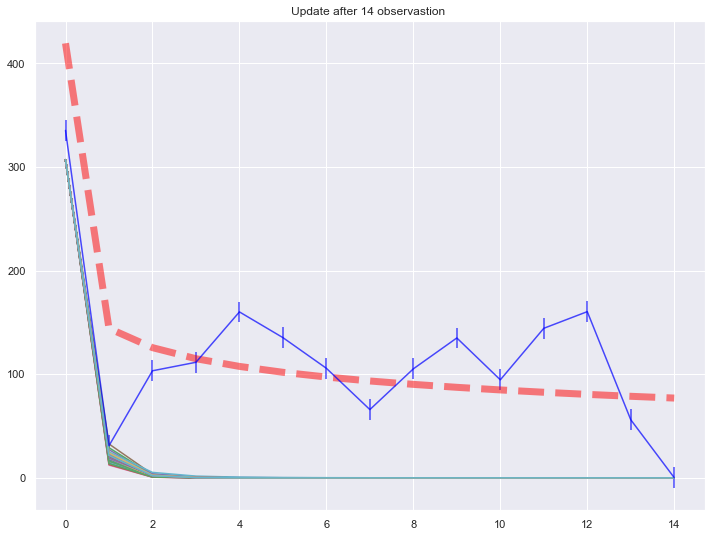

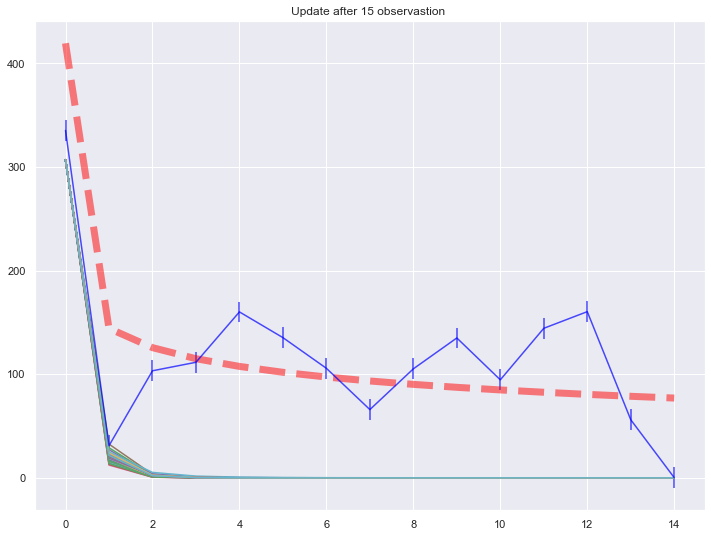

In [60]:
plotter(Arps_updated,FM='Arps',tme=prod_time)

In [61]:
# plt.figure(figsize=(12,9))
# plt.errorbar(indx,np.asarray(obs_SEM), yerr = 20,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=5,alpha=0.4)
# # plt.plot(aP)
# plt.plot(indx,Arps_updated[3,:,1:].T,alpha=.5)
# plt.ylabel('Rate')
# plt.xlabel('time')
# plt.title('Posteroir and likelyhood')
# plt.legend()
# plt.show()

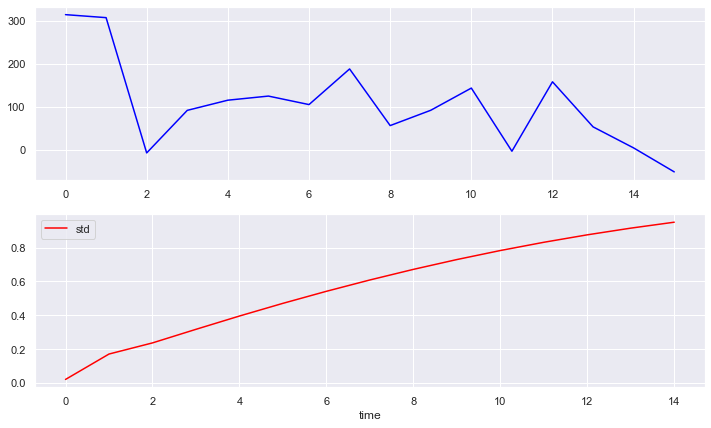

In [62]:

fig = plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
plt.plot(Arps_updated[4,:,:].mean(axis=0),label='mean',color = "blue")

plt.subplot(2, 1, 2)
plt.plot(Arps_updated[4,:,1:].std(axis=0),label='std',color = 'red')
plt.legend()
plt.xlabel('time')
plt.show()




In [63]:
SEM_update= EnKF(mf_k=np.matrix(SEM_par[0,:]),                      #state_variables,, 
                    Xf_k=np.array(QS_DF),                            #dynamic_reservoir_model
                    gf_k=np.array(QS_DF),                           #observation_current
                    d=np.asarray(obs_SEM).T,                        #measurements
                    par1=(SEM_par[1,:]),                            #paramter 1
                    par2=(SEM_par[2,:]),                            #paramter 2
                    r=50,                                           #R measurments error
                    FM='SEM',                                       #foreward model
                    pa_up=False,                                    # updating paramter
                    tme = prod_time)
# print("RMSE SEM_update/measrment is ",RMSE ( (np.array(obs_SEM) * np.ones((N,len(T)))),SEM_update[4,:,1:]))
# print("RMSE SEM_update/ture is ",RMSE ( (np.array(tr) * np.ones((N,len(T)))),SEM_update[4,:,1:]))

  0%|          | 0/15 [00:00<?, ?it/s]

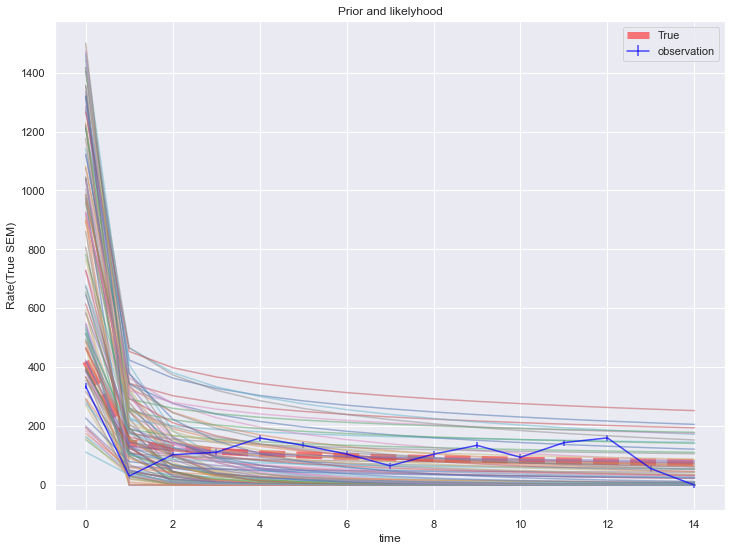

In [64]:
plt.figure(figsize=(12,9))
plt.errorbar(T,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7,)
plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=7,alpha=.5)
plt.plot(T,QS_DF,alpha=.5)
plt.ylabel('Rate(True SEM)')
plt.xlabel('time')
plt.title('Prior and likelyhood')
plt.legend()
plt.show()

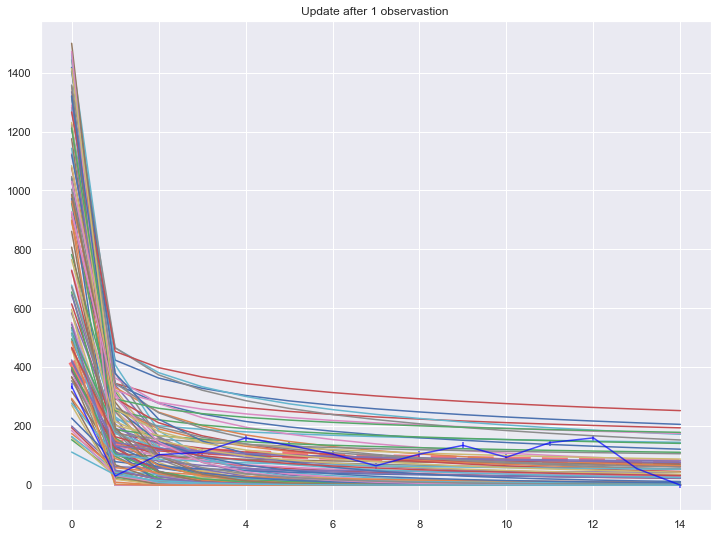

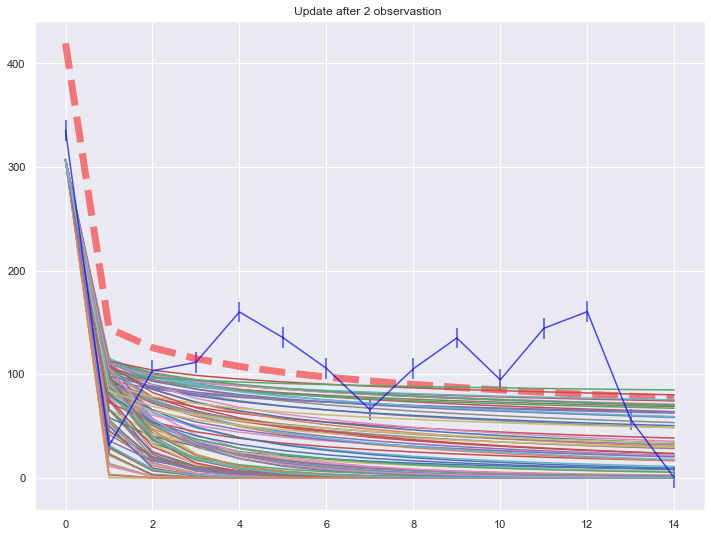

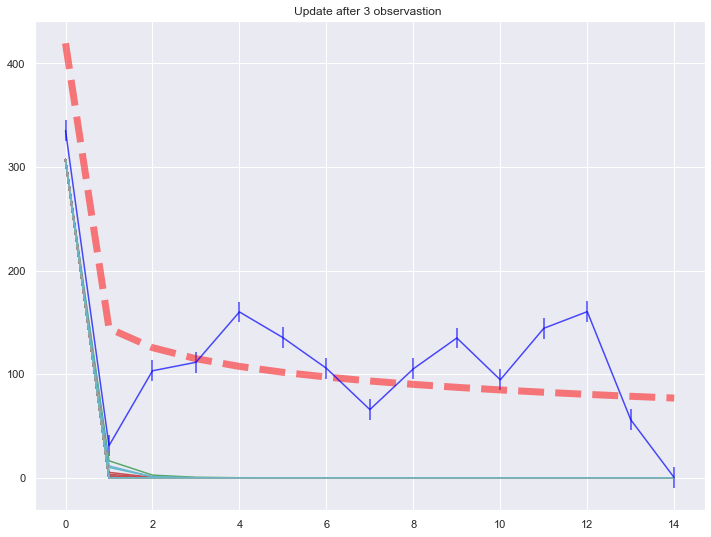

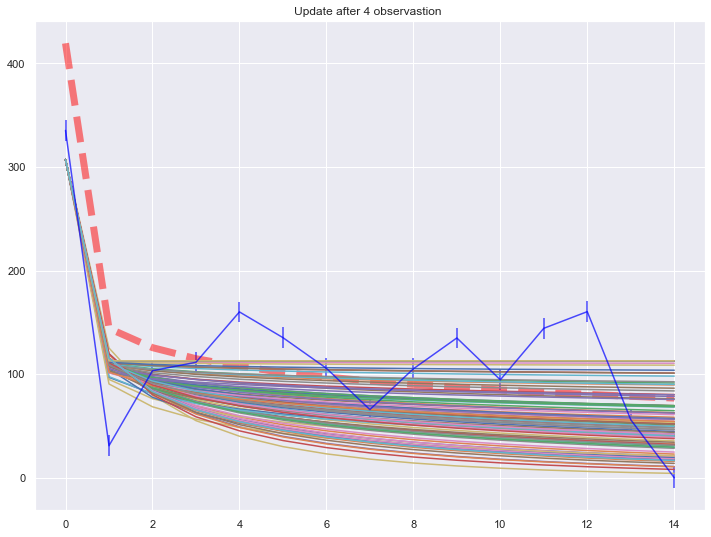

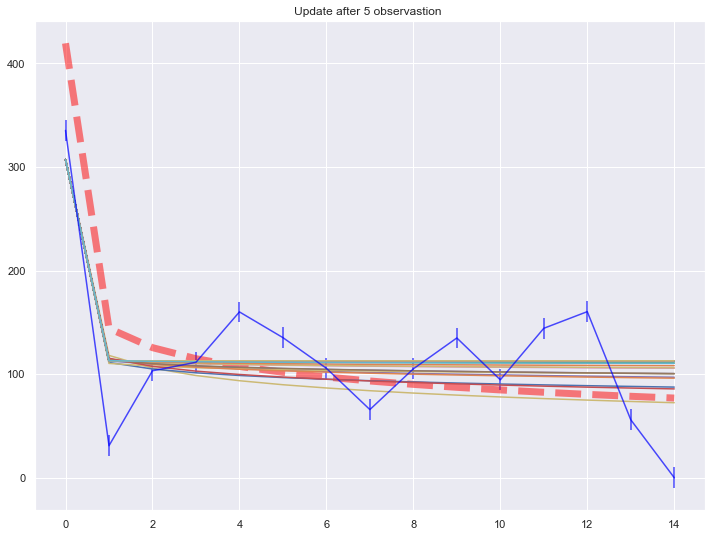

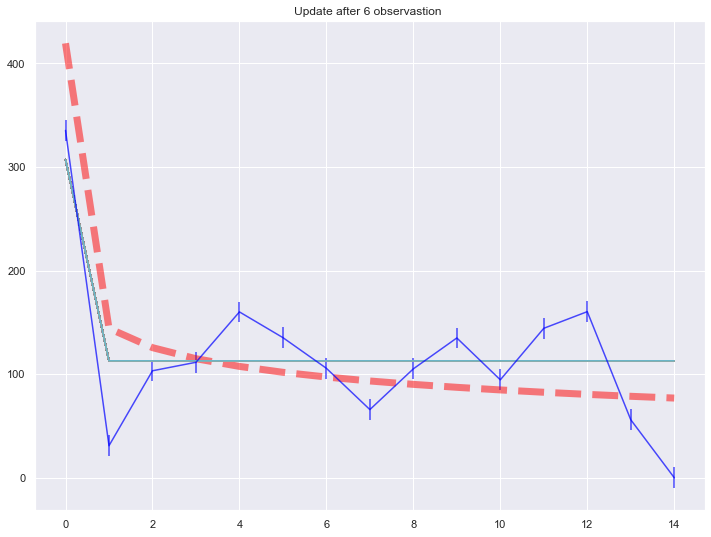

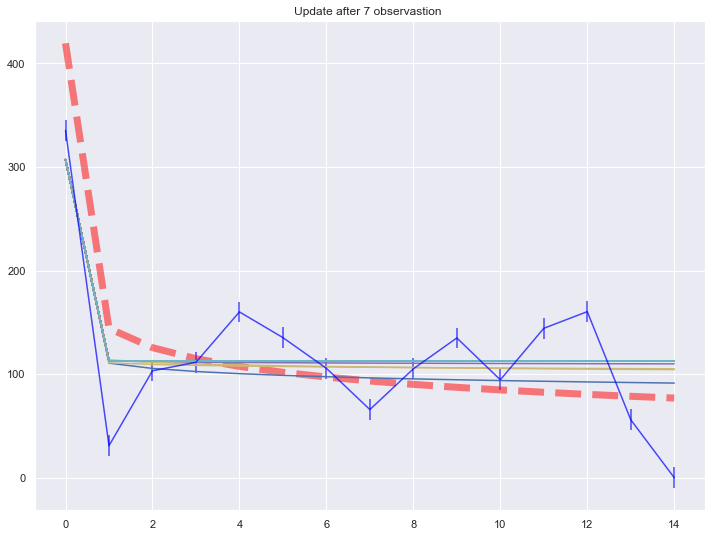

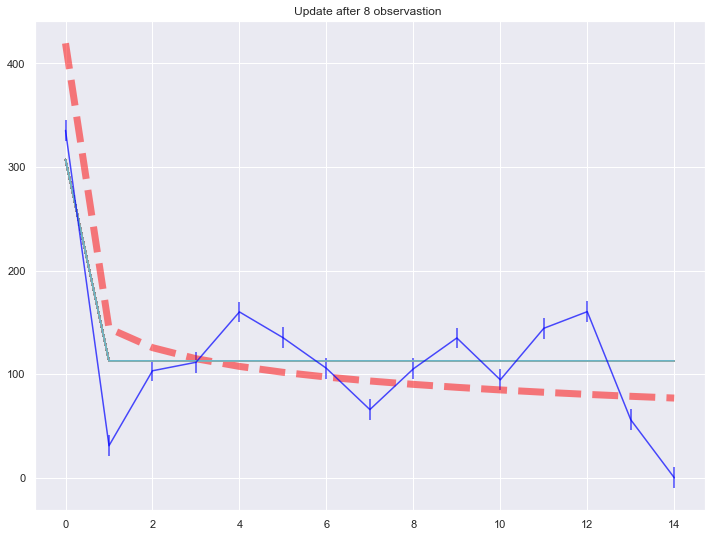

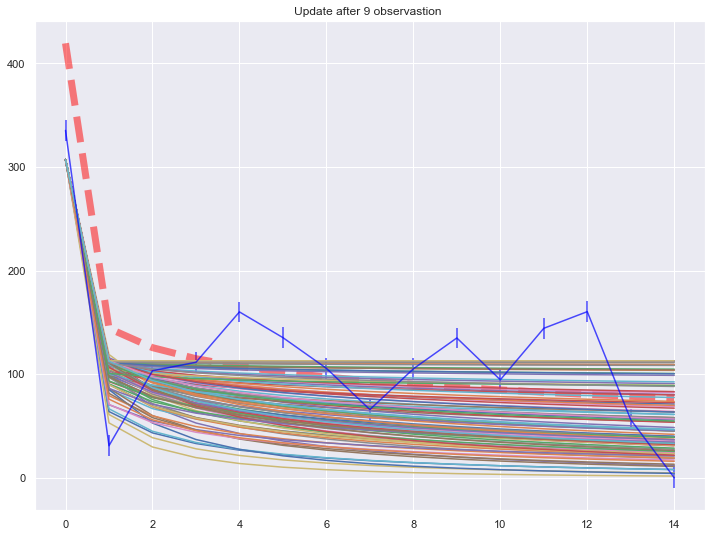

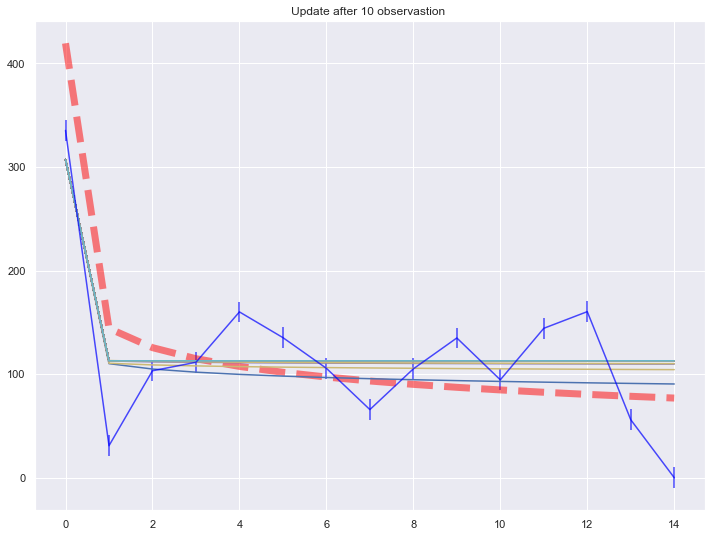

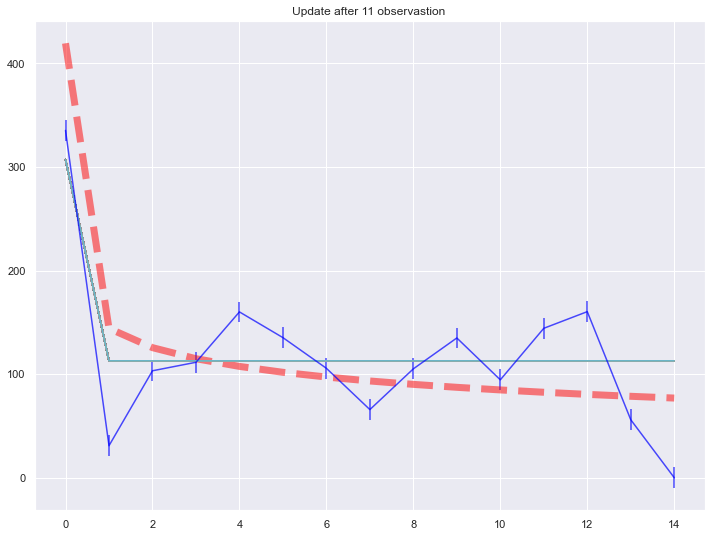

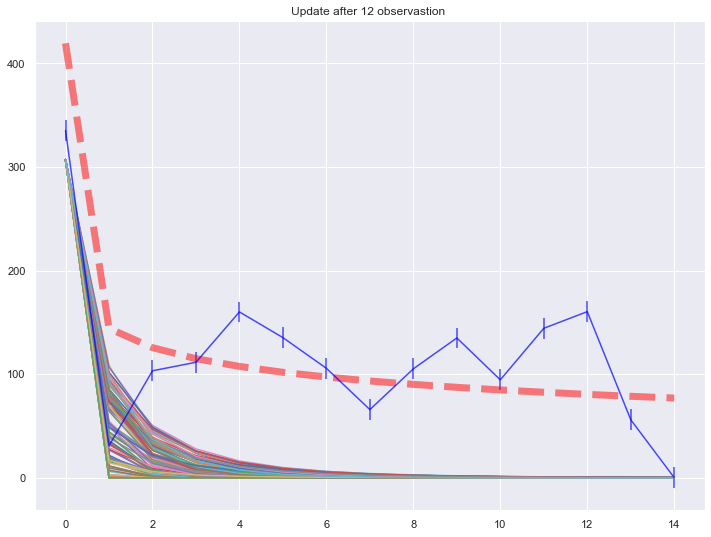

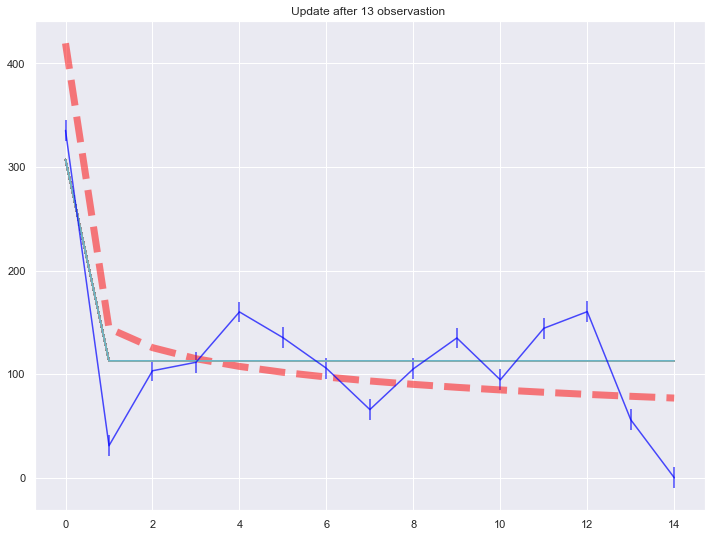

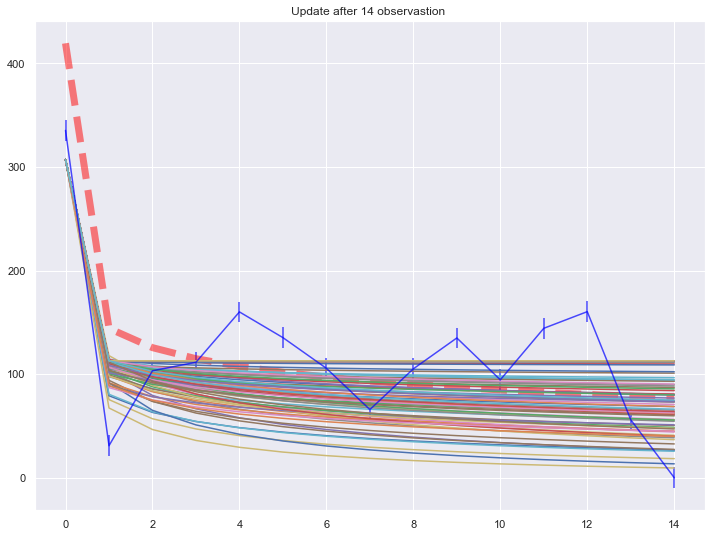

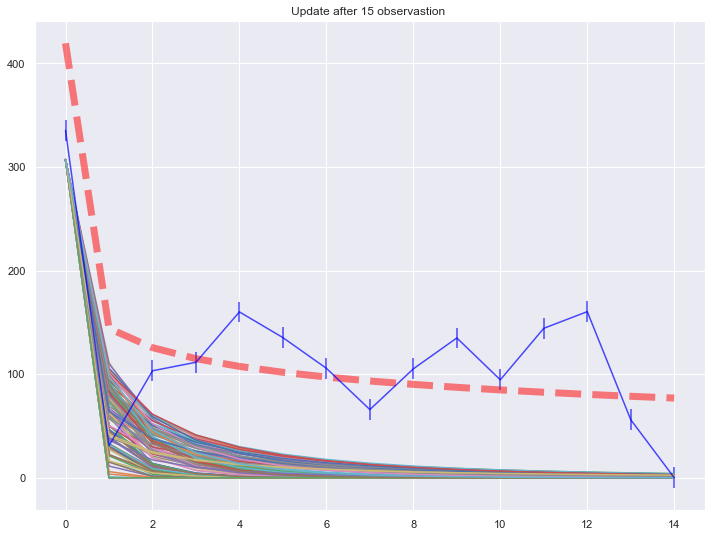

In [65]:
plotter(SEM_update,FM='SEM',tme=prod_time)


In [66]:
# plt.figure(figsize=(12,9))
# plt.errorbar(indx,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=1.5)
# plt.plot(indx,(SEM_update[4,:,1:]).T,alpha=.4)
# plt.ylabel('Rate(Updated SEM)')
# plt.xlabel('time')
# plt.title('Posterior and likelyhood')
# plt.legend()
# plt.show()

###  Mean and Std

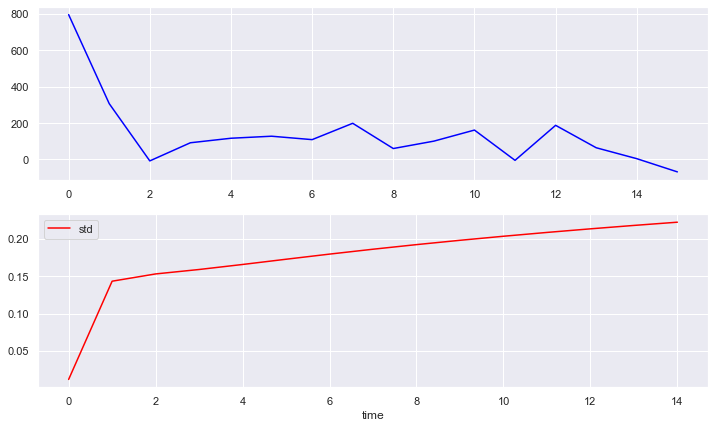

In [67]:


fig = plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
plt.plot(SEM_update[4,:,:].mean(axis=0),label='mean',color = "blue")

plt.subplot(2, 1, 2)
plt.plot(SEM_update[4,:,1:].std(axis=0),label='std',color = 'red')
plt.legend()
plt.xlabel('time')
plt.show()

In [68]:
# plt.figure(figsize = (12,7))
# plt.plot(((np.array(tr) * np.ones((N,prod_time))).T-SEM_update[4,:,1:].T).mean(axis=1),label='mean')
# plt.plot(((np.array(tr) * np.ones((N,prod_time))).T-SEM_update[4,:,1:].T).std(axis=1),label='std')
# plt.legend()

In [69]:
def interpolator(df, xx):
    srt=df.sort_values(by=['x'], axis=0, ascending=True, inplace=False)
    mu = np.interp(xx,srt['x'],srt['mean'])
    std = np.interp(xx,srt['x'],srt['STD'])
    error_trm = ss.norm.rvs(mu,std**1,1)
    return error_trm
    

### EnKF V4 with adding model error

In [70]:
def EnKF_error(mf_k,Xf_k, gf_k, d, par1, par2, FM, pa_up ,er_cof,recur_error,st_df=0, r=.5):
    np.random.seed(663)
    random.seed(586)
    R = r * np.eye(1)
    N=mf_k.shape[1]
    nobs=(obs_SEM).shape[0]
    emf_K = np.zeros(mf_k.shape)
    Y_f_ = np.zeros([5,N,nobs+1])
    P_f_ = np.zeros([5,5,nobs+1])
    Y_a_ = np.zeros([5,N,nobs+1])
    P_a_ = np.zeros([5,5,nobs+1])
    Y_f_[0,:,0] = mf_k + emf_K
    Y_f_[1,:,0] = par1; Y_f_[2,:,0] = par2
    Y_f_[3,:,0] = mf_k + emf_K
    Y_f_[4,:,0] = mf_k + emf_K
    P_f_[:,:,0] = np.cov(Y_f_[:,:,0])
    Y_a_[0,:,0] = mf_k + emf_K
    Y_a_[1,:,0] = par1; Y_a_[2,:,0] = par2
    Y_a_[3,:,0] = mf_k + emf_K
    Y_a_[4,:,0] = mf_k + emf_K
    P_a_[:,:,0] = np.cov(Y_a_[:,:,0])
    if recur_error == False:
#####################################    
        Q0 = Y_a_[0,:,0]
        Q0e = np.zeros(Q0.shape)
        for v in range(Q0.shape[0]):
            Q0e[v] = interpolator(st_df,Q0[v])
        Q0=(Q0)+ er_cof* Q0e 
#####################################    
    for t in tqdm(range(nobs)):
        Q0 = Y_a_[0,:,t]
#####################################
        if recur_error == True:
            Q0e = np.zeros(Q0.shape)
            for v in range(Q0.shape[0]):
                Q0e[v] = interpolator(st_df,Q0[v])
            Q0=(Q0)+er_cof*Q0e    
#####################################

        if FM=='Arps':
            Qt=ArpsRate(np.array([range(t+1)]).T, Q0 ,Y_a_[1,:,t] , Y_a_[2,:,t])          #Arps(time, Q, Di0, b)
        else:
            Qt=SEM(np.array(([range(t+1)])*N).T, Q0 ,Y_a_[1,:,t],Y_a_[2,:,t])             #SEM(time, Q, Tau, n)

        #### recheck this part
        Y_f_[0,:,t+1] = Q0
        Y_f_[3,:,t+1] = Qt[t,:]
        Y_f_[4,:,t+1] = Qt[t,:]
        if pa_up== True: 
            Y_f_[1,:,t+1] = Y_a_[1,:,t];Y_f_[2,:,t+1] = Y_a_[2,:,t]
        else:
            Y_f_[1,:,t+1] = par1;Y_f_[2,:,t+1] = par2
        Y_f_now = Y_f_[:,:,t+1]
        P_f_now = np.cov(Y_f_now)*N/np.sqrt(N-1)
        P_f_[:,:,t+1] = P_f_now

        H = np.array([Qt[t,:] @  sla.pinv(Y_f_now)])   
        K = P_f_now @ H.T @ sla.pinv(H @ P_f_now @ H.T + R)
        y = d[t] + ss.norm.rvs(0,r,1) # measurement + noise
        
        print("iteration", t)

        print('p2',Y_f_now[2,2:4])
        Y_a_now = Y_f_now + K @ (y - H @ Y_f_now)
#         print("iteration", t)
        print('p1',Y_f_now[1,2:4])
        print('p2',Y_f_now[2,2:4])


        Y_a_now[1,:] = np.where(Y_a_now[1,:]<=0,10**-5, Y_a_now[1,:])
        Y_a_now[2,:] = np.where(Y_a_now[2,:]<=0,10**-5, Y_a_now[2,:])
        P_a_now = np.cov(Y_a_now)
        Y_a_[:,:,t+1] = Y_a_now
        P_a_[:,:,t+1] = P_a_now
    return Y_a_

In [71]:
Ar_er_up= EnKF_error(mf_k=np.matrix(para_mat[0,:]),                      #state_variables,, 
                    Xf_k=np.array(ARP_DF),                                 #dynamic_reservoir_model
                    gf_k=np.array(ARP_DF),                                 #observation_current
                    d=np.asarray(obs_SEM).T,                              #measurements
                    par1=(para_mat[1,:]),                                  #DCA paramter 1
                    par2=(para_mat[2,:]),                                  #DCA paramter 2
                    r=50,                                                 #R measurments error
                    FM='Arps',                                             #foreward model
                    st_df=df_out,                                         #error paramters
                    pa_up=True,                                          #updating paramter
                    er_cof = 1,                                        #Error multiplier
                    recur_error= False)                                  #recursively error adds up'True'


  0%|          | 0/15 [00:00<?, ?it/s]

iteration 0
p2 [1.00000000e-04 6.98676411e-01]
p1 [3. 3.]
p2 [1.00000000e-04 6.98676411e-01]
iteration 1
p2 [0.02020479 0.46032444]
p1 [3.00693004 2.91784098]
p2 [0.02020479 0.46032444]
iteration 2
p2 [0.5245696  0.62515198]
p1 [2.55441038 2.76995655]
p2 [0.5245696  0.62515198]
iteration 3
p2 [1.77484448 1.82115366]
p1 [4.45812309 4.59103097]
p2 [1.77484448 1.82115366]
iteration 4
p2 [1.98162085 2.02175956]
p1 [4.94007765 5.05860338]
p2 [1.98162085 2.02175956]
iteration 5
p2 [2.644641   2.68045991]
p1 [6.57998311 6.68782431]
p2 [2.644641   2.68045991]
iteration 6
p2 [2.91250276 2.94531736]
p1 [7.28380663 7.3837538 ]
p2 [2.91250276 2.94531736]
iteration 7
p2 [2.79407398 2.82463321]
p1 [6.9661775 7.0600757]
p2 [2.79407398 2.82463321]
iteration 8
p2 [2.87562108 2.90431821]
p1 [7.18546623 7.27435707]
p2 [2.87562108 2.90431821]
iteration 9
p2 [3.04004108 3.06721156]
p1 [7.63218968 7.71693267]
p2 [3.04004108 3.06721156]
iteration 10
p2 [3.09986995 3.12577442]
p1 [7.79676314 7.87802368]
p2 [3

In [72]:
# RMSE with model error/ measurment is  2.184189465174983
# RMSE with model error/ ture is  14.568135512475697

In [73]:
# plt.figure(figsize=(12,9))
# plt.errorbar(indx,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=1.5)
# plt.plot(indx,(Ar_er_up[4,:,1:]).T,alpha=.4)
# plt.ylabel('Rate')
# plt.xlabel('time')
# plt.title('Posterior and likelyhood')
# plt.legend()
# plt.show()

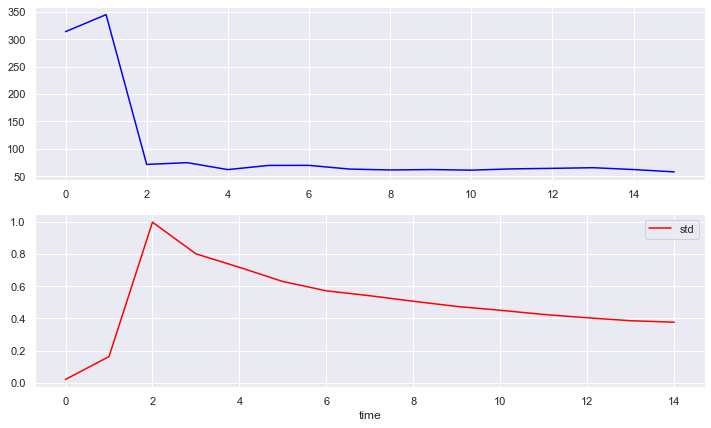

In [74]:
fig = plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
plt.plot(Ar_er_up[4,:,:].mean(axis=0),label='mean',color = "blue")

plt.subplot(2, 1, 2)
plt.plot(Ar_er_up[4,:,1:].std(axis=0),label='std',color = 'red')
plt.legend()
plt.xlabel('time')
plt.show()

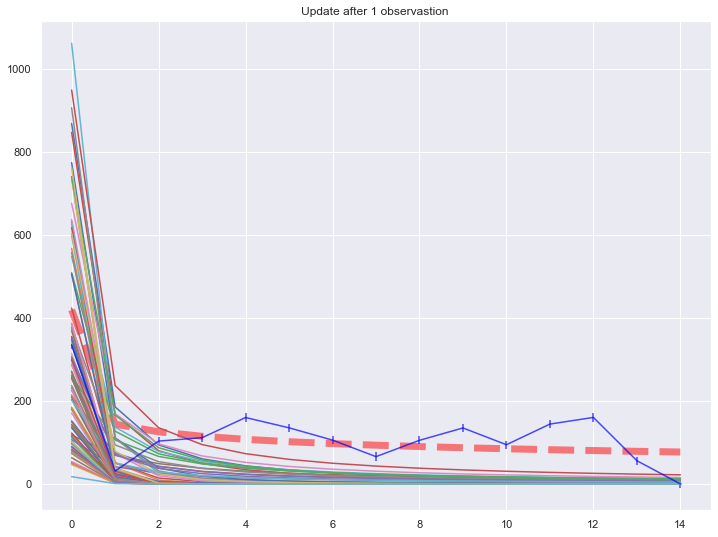

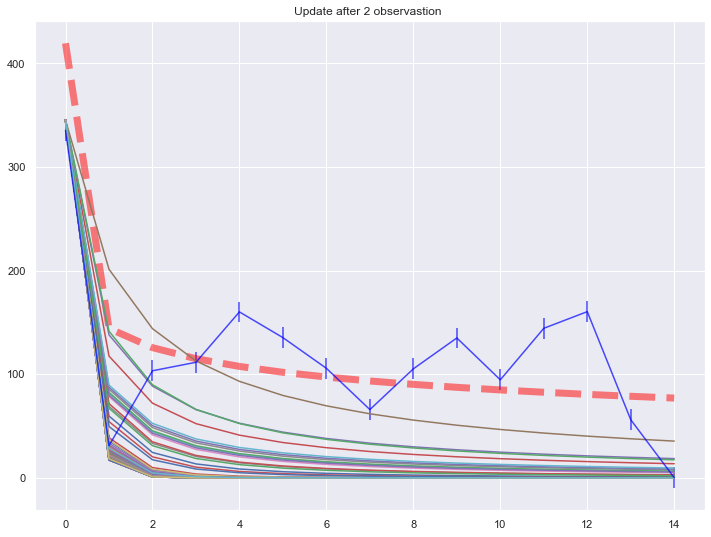

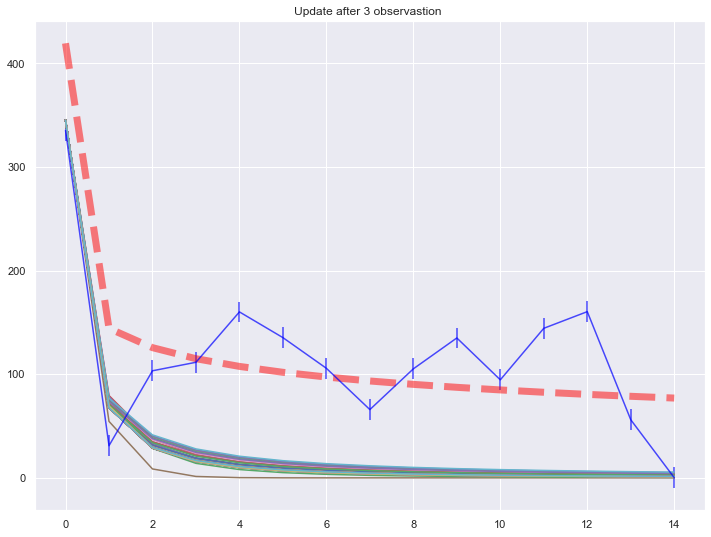

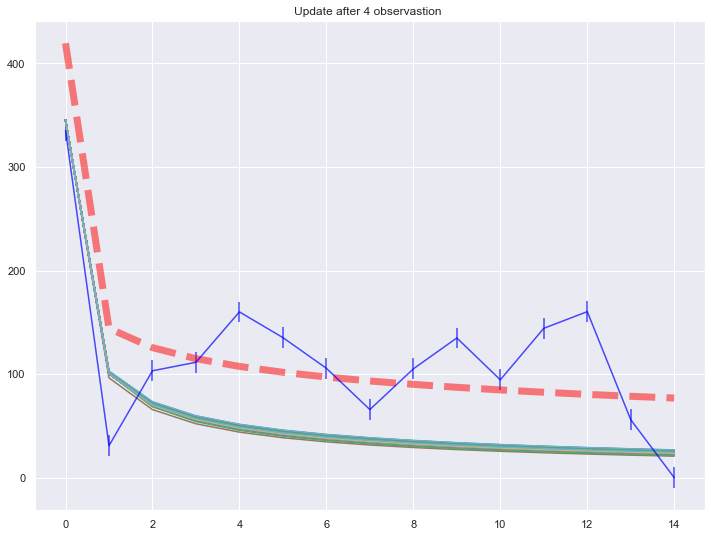

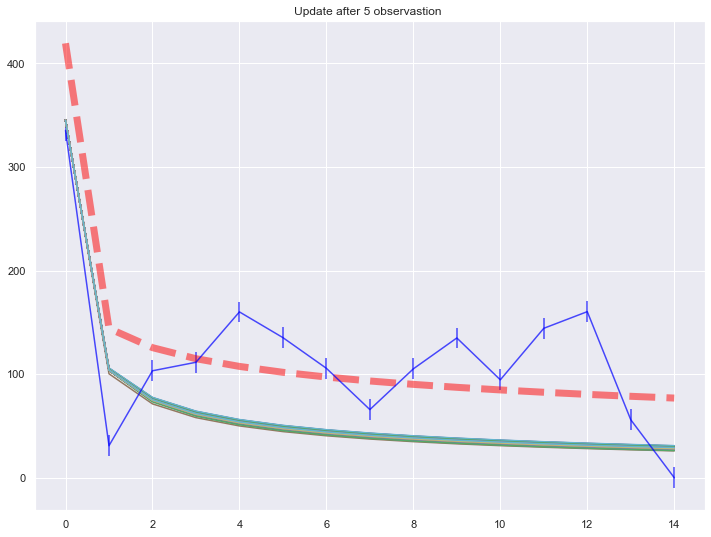

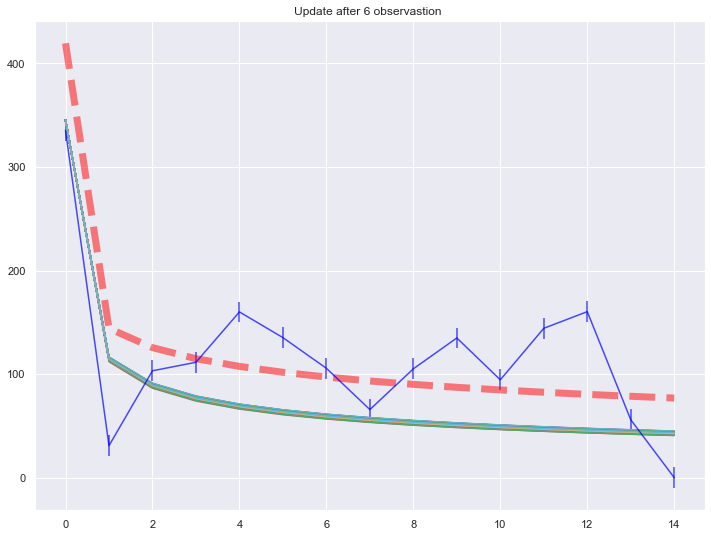

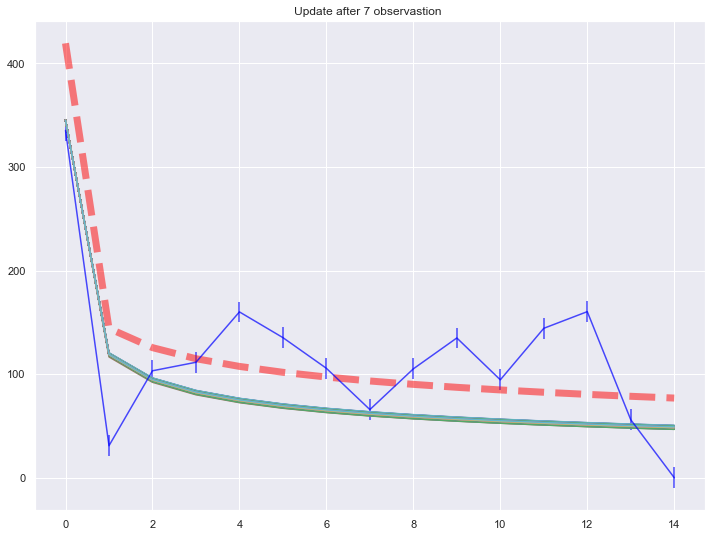

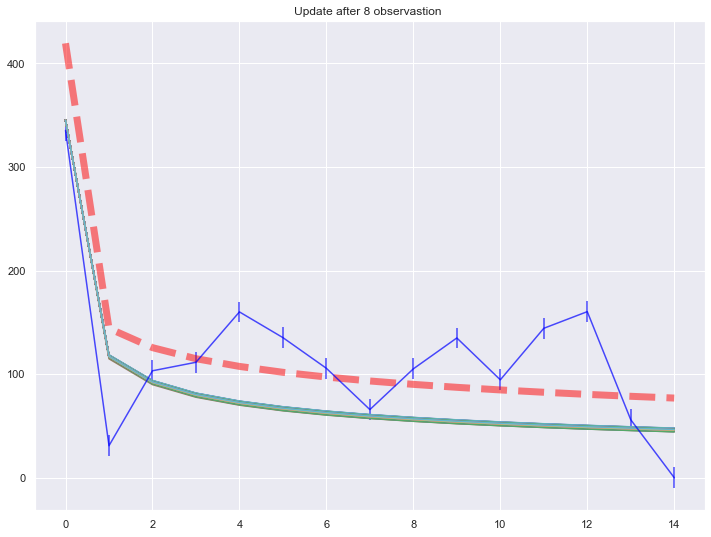

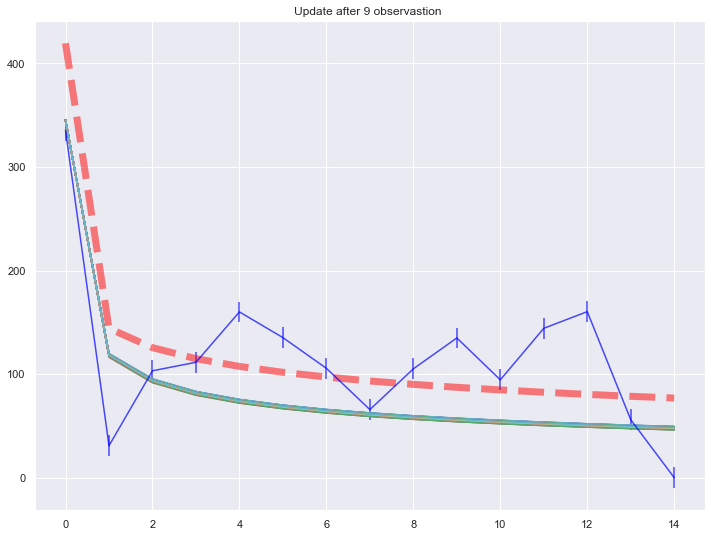

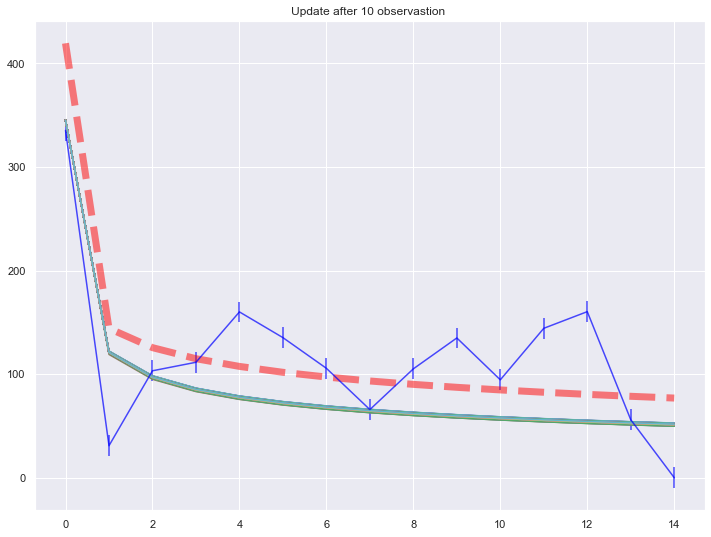

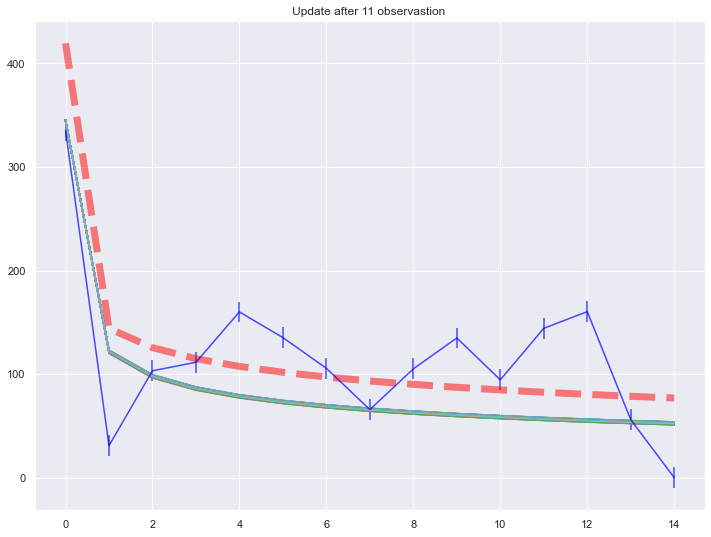

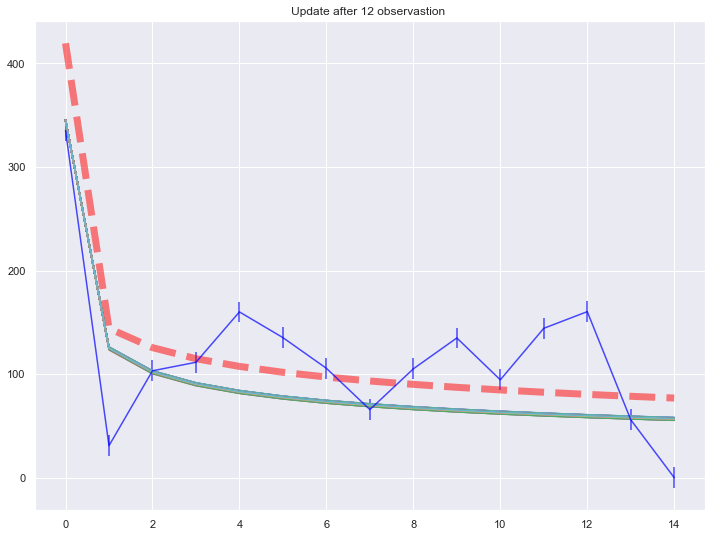

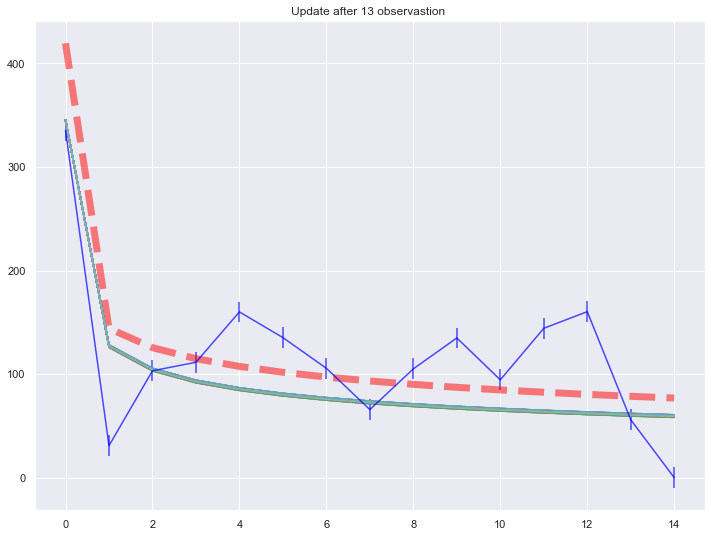

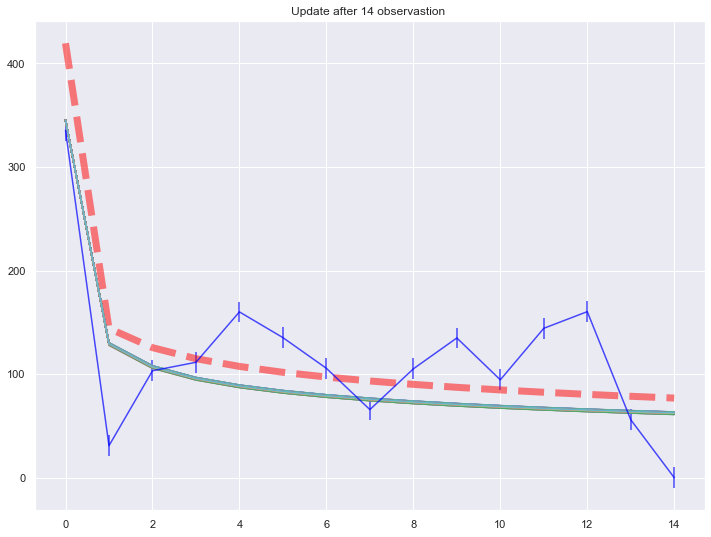

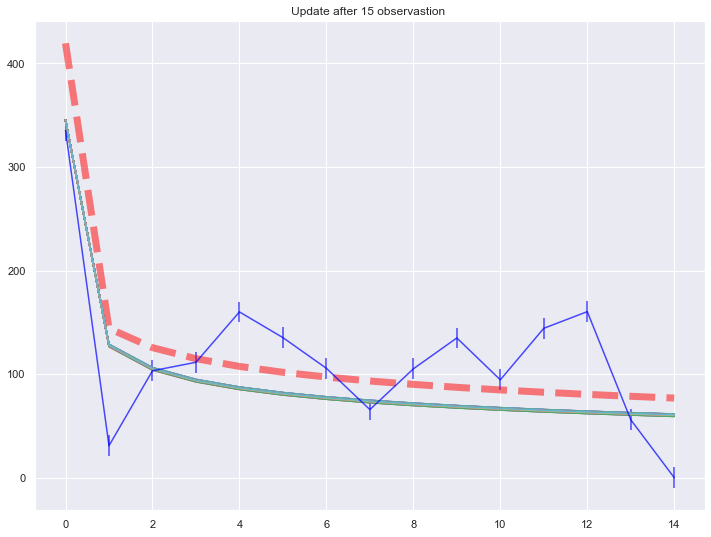

In [75]:
plotter(Ar_er_up,FM='Arps',tme=prod_time)


In [76]:
error(Ar_er_up,FM='Arps',tme=prod_time,tr =tr, obs= obs_SEM)

RMSE SEM_update/measrment is  45.018968258686144
RMSE SEM_update/ture is  25.110191544444593
MAPE SEM_update/measrment is  45.011393915989174
MAPE SEM_update/ture is  25.107139502816928


In [77]:
error(SEM_update,FM='SEM',tme=prod_time,tr =tr, obs= obs_SEM)

RMSE SEM_update/measrment is  95.42515144460198
RMSE SEM_update/ture is  97.77257456776069
MAPE SEM_update/measrment is  95.31097552171512
MAPE SEM_update/ture is  97.68566838759321


In [78]:
error(Arps_updated,FM='Arps',tme=prod_time,tr =tr, obs= obs_SEM)

RMSE SEM_update/measrment is  94.2389789396695
RMSE SEM_update/ture is  96.99576732966007
MAPE SEM_update/measrment is  94.21548304631433
MAPE SEM_update/ture is  96.99368487085158
